# Run plots

Baseline:
- cosine similarity loss for objects
- learned slot queries
- slot attention

Interesting parameters:
- patch size
- number of layers/heads in backbone
- object loss type
- object query types
- crop scale
- embedding dimension

Interesting metrics:
- IoU segmentation
- AP classification

In [1]:
import json
from collections import defaultdict
from typing import Any, Iterator, Mapping, Tuple, Union

import matplotlib.lines as mlines
import matplotlib.patches as mpatch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import wandb
from IPython.display import Image
from matplotlib.ticker import PercentFormatter
from omegaconf import OmegaConf
from pathlib import Path

StringDict = Mapping[str, Union[Any, "StringDict"]]


def to_dotlist(
    d: StringDict, prf: Tuple[str, ...] = tuple()
) -> Iterator[Tuple[str, Any]]:
    """Iterate over a flattened dict using dot-separated keys.

    Args:
        d: a hierarchical dictionary with strings as keys
        prf: tuple of prefixes used for recursion

    Examples:
        Flatten a dict::

        >>> print(*to_dotlist({'a': {'b': {}, 'c': 1, 'd': [2]}, 'x': []}), sep="\\n")
        ('a.b', {})
        ('a.c', 1)
        ('a.d', [2])
        ('x', [])

    Yields:
        Tuples of dot-separated keys and values. Call :func:``dict`` on the returned
        iterator to build a flat dict.
    """
    for k, v in d.items():
        if isinstance(v, dict) and len(v) > 0:
            yield from to_dotlist(v, prf=(*prf, k))
        else:
            yield ".".join((*prf, k)), v
            
d = Path('08-Runs')
d.mkdir(exist_ok=True)

## All runs

In [2]:
df = []
api = wandb.Api()
for r in api.runs("baldassarrefe/iclr-osc-22"):
    if r.state == "running":
        continue
    if 'overfit' in r.tags:
        continue

    cfg = json.loads(r.json_config)
    cfg = {k: v["value"] for k, v in cfg.items()}
    cfg = dict(to_dotlist(cfg))

    summary = {
        k.replace("/", "."): v
        for k, v in dict(r.summary).items()
        if isinstance(v, (float, int))
    }
    if 'ignore-vqa' in r.tags:
        summary = {k:v for k,v in summary.items() if not k.startswith('vqa')}
    if len(summary) == 0:
        continue
    if summary["epoch"] < 4:
        continue

    df.append(
        dict(
            to_dotlist(
                {
                    "run": r.name,
                    "cfg": cfg,
                    "s": summary,
                }
            )
        )
    )


df = pd.DataFrame(df)
df

,run,cfg.data.val.max_samples,cfg.data.viz.seed,cfg.data.viz.max_samples,cfg.data.viz.epoch_interval,cfg.data.name,cfg.data.test.vqa.seed,cfg.data.test.vqa.split,cfg.data.test.vqa.num_epochs,cfg.data.test.vqa.pos_weight,...,cfg.model.obj_fn.mlp_ratio,cfg.model.obj_fn.num_heads,cfg.model.obj_fn.block_drop,cfg.model.obj_fn.num_layers,cfg.model.obj_fn.block_attn_drop,cfg.training.checkpoint_interval,cfg.model.obj_queries.num_components,cfg.model.obj_fn.queries,cfg.model.obj_fn.num_objects,cfg.model.global_fn.pooling
0,mystifying-shirley-54,15000,6.676759e+15,4.0,5.0,CLEVR10,759443315.0,0.75,10000.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,blissful-bassi-92,15000,6.676759e+15,4.0,5.0,CLEVR10,759443315.0,0.75,10000.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,priceless-stallman-53,15000,6.676759e+15,4.0,5.0,CLEVR10,759443315.0,0.75,10000.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,clever-newton-13,15000,6.676759e+15,4.0,5.0,CLEVR10,759443315.0,0.75,10000.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,upbeat-cori-50,15000,6.676759e+15,4.0,5.0,CLEVR10,759443315.0,0.75,10000.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586,loving-babbage-90,15000,NaN,NaN,NaN,CLEVR10,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sample,11.0,avg
1587,vibrant-torvalds-96,15000,NaN,NaN,NaN,CLEVR10,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sample,11.0,avg
1588,ecstatic-brattain-40,15000,NaN,NaN,NaN,CLEVR10,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sample,11.0,avg
1589,practical-wright-47,15000,NaN,NaN,NaN,CLEVR10,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sample,11.0,avg


In [3]:
df_tmp = df[
    (df["cfg.model.architecture"] == "backbone-obj_fn(-global_fn-global_proj)-obj_proj")
    & (~df["s.test.iou.by_img_no_bg"].isna())
]

df_tmp = df_tmp.copy()
df_tmp["cfg.model.backbone.patch_size"] = df_tmp["cfg.model.backbone.patch_size"].astype(str)
df_tmp["cfg.data.crop_size"] = df_tmp["cfg.data.crop_size"].astype(str)
df_tmp["cfg.data.crop_scale"] = df_tmp["cfg.data.crop_scale"].astype(str)

for col in df_tmp.columns:
    if not col.startswith("cfg."):
        continue
    if len(df_tmp[col].unique()) > 1:
        display(df_tmp[col].value_counts().to_frame())

df_tmp.groupby(
    [
        "cfg.data.crop_scale",
        "cfg.model.backbone.patch_size",
        "cfg.model.backbone.embed_dim",
        "cfg.model.backbone.num_layers",
        "cfg.model.backbone.num_heads",
        "cfg.model.obj_queries.name",
        "cfg.model.obj_fn.name",
        "cfg.losses.l_objects.name",
    ]
).size().to_frame()

,cfg.data.viz.epoch_interval
5.0,1339
1.0,2


,cfg.data.test.vqa.seed
759443315.0,683


,cfg.data.test.vqa.split
0.75,683


,cfg.data.test.vqa.num_epochs
10000.0,683


,cfg.data.test.vqa.pos_weight
14.0,683


,cfg.data.test.epoch_interval
5.0,1339
1.0,2


,cfg.data.crop_scale
"[0.3, 1]",860
"[0.8, 1]",77
"[0.5, 1]",70
"[0.1, 1]",48
"[0.1, 0.3]",46
"[0.1, 0.5]",42
"[0.1, 0.9]",30
"[0.3, 0.8]",28
"[0.3, 0.5]",26
"[0.5, 0.9]",24


,cfg.model.obj_fn.name
slot-attention,1182
cross-attention,159


,cfg.model.obj_fn.num_iters
1.0,712
2.0,353
4.0,106
3.0,11


,cfg.model.obj_fn.hidden_mult
2.0,1182


,cfg.model.backbone.embed_dim
128,486
256,430
64,421
1024,2
512,2


,cfg.model.backbone.num_heads
4,1045
8,296


,cfg.model.backbone.block_drop
0.0,1302
0.2,39


,cfg.model.backbone.num_layers
2,843
4,420
6,78


,cfg.model.backbone.patch_size
"[8, 8]",752
"[4, 4]",589


,cfg.model.backbone.block_attn_drop
0.0,1302
0.2,39


,cfg.model.obj_proj.dropout
0.0,1340
0.2,1


,cfg.model.global_fn.dropout
0.0,1340
0.2,1


,cfg.model.global_proj.dropout
0.0,1340
0.2,1


,cfg.model.obj_queries.name
learned,1027
sample,289
kmeans_euclidean,25


,cfg.losses.l_global.weight
1.0,979
0.1,202
0.0,160


,cfg.losses.l_objects.name
sim_img,647
ctr_img,588
ctr_all,106


,cfg.losses.l_objects.weight
0.05,946
1.00,395


,cfg.training.batch_size
16,729
64,410
32,102
8,100


,cfg.training.num_epochs
10,968
25,329
5,41
100,2
50,1


,cfg.optimizer.weight_decay
0.0001,1252
0.0010,89


,cfg.lr_scheduler.decay.end_lr
0.0003,1256
0.0000,85


,cfg.lr_scheduler.decay.epochs
8,968
20,329
4,41
80,2
40,1


,cfg.lr_scheduler.warmup.epochs
2,968
5,329
1,41
20,2
10,1


,cfg.model.obj_fn.drop_path
0.0,159


,cfg.model.obj_fn.mlp_ratio
2.0,159


,cfg.model.obj_fn.num_heads
4.0,159


,cfg.model.obj_fn.block_drop
0.0,159


,cfg.model.obj_fn.num_layers
2.0,113
1.0,40
4.0,6


,cfg.model.obj_fn.block_attn_drop
0.0,159


,cfg.training.checkpoint_interval
5.0,579


,cfg.model.obj_queries.num_components
12.0,125
48.0,77
24.0,67
64.0,8
32.0,5
16.0,3
11.0,2
1.0,1


0
cfg.data.crop_scale cfg.model.backbone.patch_size cfg.model.backbone.embed_dim cfg.model.backbone.num_layers cfg.model.backbone.num_heads cfg.model.obj_queries.name cfg.model.obj_fn.name cfg.losses.l_objects.name   
[0.1, 0.3]          [4, 4]                        64                           2                             4                            kmeans_euclidean           slot-attention        sim_img                    1
                                                                                                                                          learned                    slot-attention        sim_img                    4
                                                  128                          2                             4                            learned                    cross-attention       sim_img                    3
                                                                                                                                                                     slot-attention        sim_img                    8
                                                  256                          2                             4                            learned                    cross-attention       sim_img                    3
...                                                                                                                                                                                                                  ..
[0.9, 1]            [4, 4]                        256                          2                             4                            learned                    slot-attention        sim_img                    8
                                                                                                             8                            learned                    slot-attention        sim_img                    2
                    [8, 8]                        64                           2                             4                            learned                    slot-attention        sim_img                    1
                                                  128                          2                             4                            learned                    slot-attention        sim_img                    1
                                                  256                          2                             4                            learned                    slot-attention        sim_img                    1

[300 rows x 1 columns]

## Contrastive loss vs cosine loss

s.test.iou.by_img_no_bg


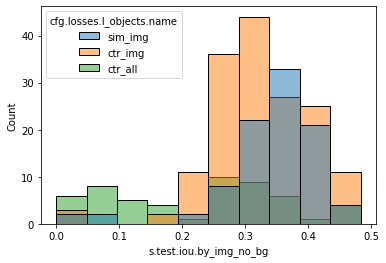

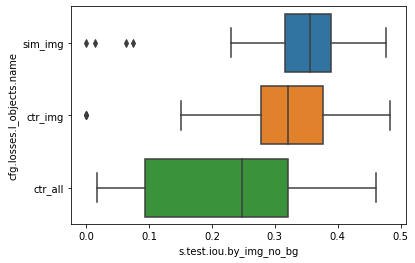

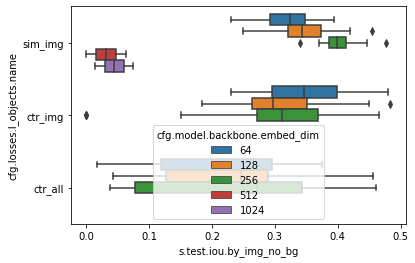

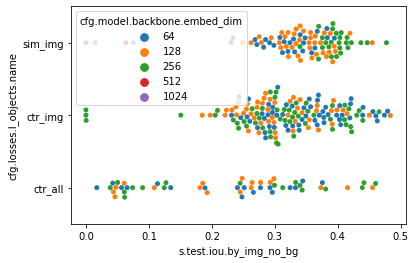

s.vqa.ap


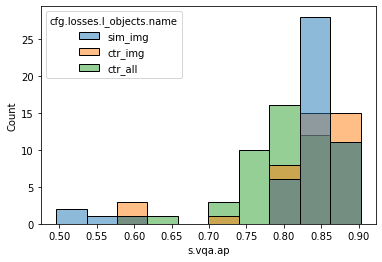

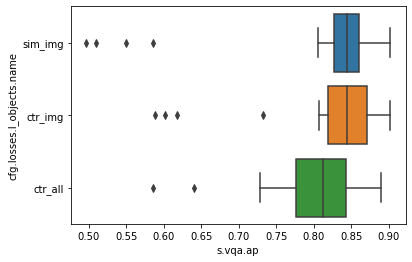

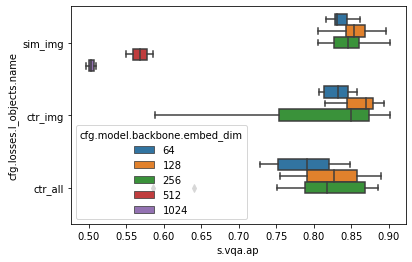

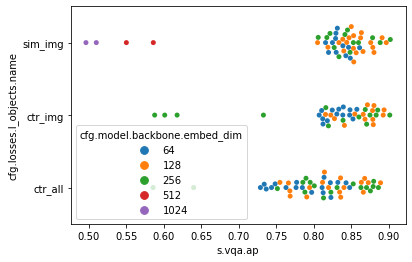

In [4]:
for metric in ["s.test.iou.by_img_no_bg", "s.vqa.ap"]:
    print(metric)

    df_tmp = df[
        (df["cfg.model.architecture"] == "backbone-obj_fn(-global_fn-global_proj)-obj_proj")
        # & (df["cfg.model.backbone.patch_size"].map(lambda v: v == [8, 8]))
        # & (df["cfg.model.backbone.embed_dim"] == 128)
        # & (df["cfg.model.backbone.num_layers"] == 2)
        # & (df["cfg.model.backbone.num_heads"] == 4)
        & (df["cfg.data.crop_scale"].map(lambda v: v == [0.3, 1.0]))
        & (df["cfg.model.obj_queries.name"] == "learned")
        & (df["cfg.model.obj_fn.name"] == "slot-attention")
        & (df["cfg.losses.l_objects.name"].isin({"ctr_all", "ctr_img", "sim_img"}))
        & (df["cfg.losses.l_global.weight"] > 0.0)
        & (~df[metric].isna())
    ]

    sns.histplot(
        data=df_tmp,
        x=metric,
        hue="cfg.losses.l_objects.name",
        bins=10,
    )
    plt.show()

    sns.boxplot(
        data=df_tmp,
        x=metric,
        y="cfg.losses.l_objects.name",
    )
    plt.show()

    sns.boxplot(
        data=df_tmp,
        x=metric,
        y="cfg.losses.l_objects.name",
        hue="cfg.model.backbone.embed_dim",
    )
    plt.show()

    sns.swarmplot(
        data=df_tmp,
        x=metric,
        y="cfg.losses.l_objects.name",
        hue="cfg.model.backbone.embed_dim",
    )
    plt.show()

s.test.iou.by_img_no_bg


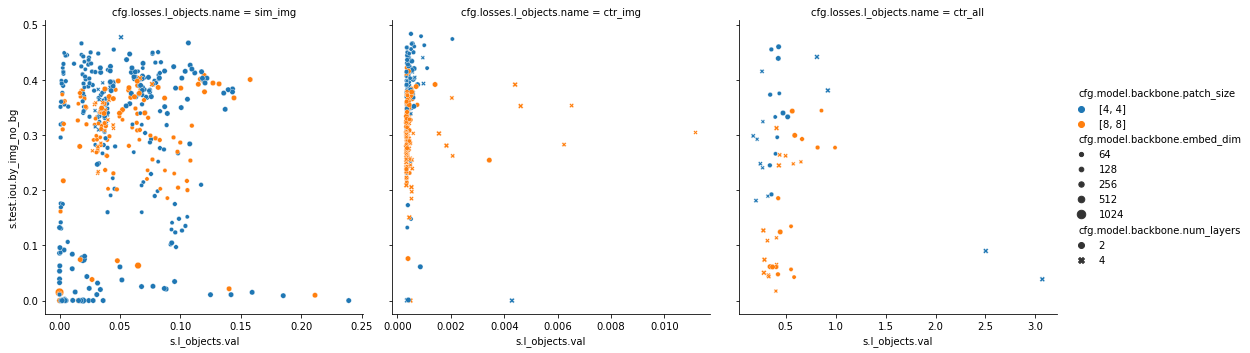

s.vqa.ap


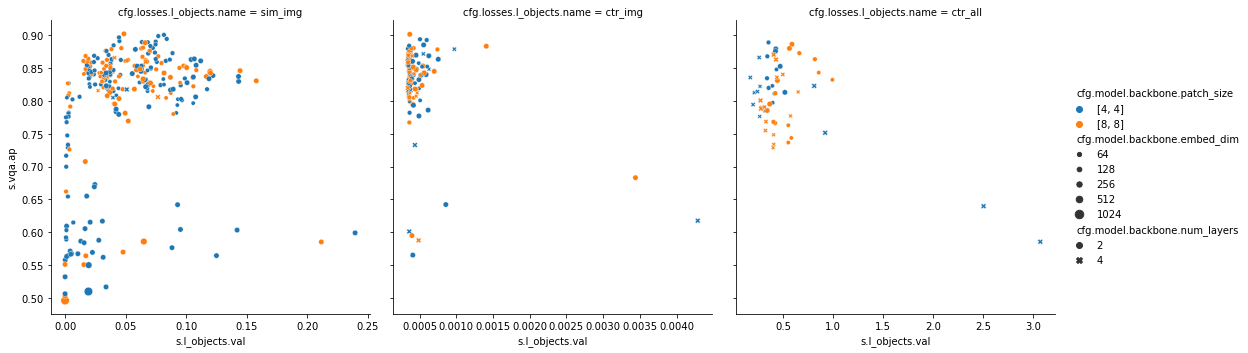

In [5]:
for metric in ["s.test.iou.by_img_no_bg", "s.vqa.ap"]:
    print(metric)
    
    df_tmp = df[
        (df["cfg.model.architecture"] == "backbone-obj_fn(-global_fn-global_proj)-obj_proj")
        # & (df["cfg.model.backbone.patch_size"].map(lambda v: v == [8, 8]))
        # & (df["cfg.model.backbone.embed_dim"] == 64)
        # & (df["cfg.model.backbone.num_layers"] == 2)
        # & (df["cfg.model.backbone.num_heads"] == 4)
        # & (df["cfg.data.crop_scale"].map(lambda v: v == [0.3, 1.0]))
        & (df["cfg.model.obj_queries.name"] == "learned")
        & (df["cfg.model.obj_fn.name"] == "slot-attention")
        & (df["cfg.losses.l_objects.name"].isin({"ctr_all", "ctr_img", "sim_img"}))
        & (df["cfg.losses.l_global.weight"] > 0.0)
        & (~df[metric].isna())
    ]

    df_tmp = df_tmp.copy()
    df_tmp["cfg.data.crop_scale"] = df_tmp["cfg.data.crop_scale"].astype(str)
    df_tmp["cfg.model.backbone.patch_size"] = df_tmp[
        "cfg.model.backbone.patch_size"
    ].astype(str)
    df_tmp.sort_values(
        [
            "cfg.data.crop_scale",
            "cfg.model.backbone.patch_size",
        ],
        inplace=True,
    )

    sns.relplot(
        data=df_tmp,
        x="s.l_objects.val",
        y=metric,
        col="cfg.losses.l_objects.name",
        hue="cfg.model.backbone.patch_size",
        facet_kws=dict(sharex=False),
        size="cfg.model.backbone.embed_dim",
        style="cfg.model.backbone.num_layers",
    )
    plt.show()

s.test.iou.by_img_no_bg


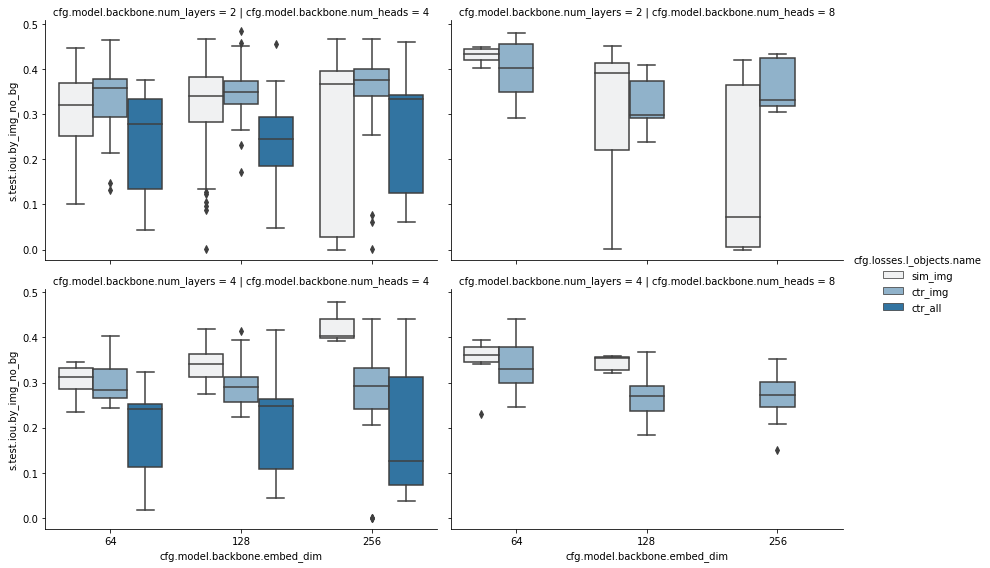

s.vqa.ap


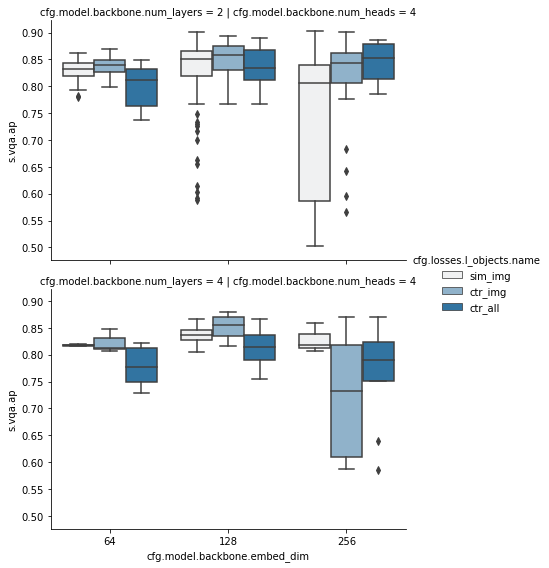

In [6]:
for metric in ["s.test.iou.by_img_no_bg", "s.vqa.ap"]:
    print(metric)
    
    df_tmp = df[
        (df["cfg.model.architecture"] == "backbone-obj_fn(-global_fn-global_proj)-obj_proj")
        # & (df["cfg.model.backbone.patch_size"].map(lambda v: v == [8, 8]))
        # & (df["cfg.model.backbone.embed_dim"] == 64)
        # & (df["cfg.model.backbone.num_layers"] == 2)
        # & (df["cfg.model.backbone.num_heads"] == 4)
        # & (df["cfg.data.crop_scale"].map(lambda v: v == [0.3, 1.0]))
        & (df["cfg.model.obj_queries.name"] == "learned")
        & (df["cfg.model.obj_fn.name"] == "slot-attention")
        & (df["cfg.losses.l_objects.name"].isin({"ctr_all", "ctr_img", "sim_img"}))
        & (df["cfg.losses.l_global.weight"] > 0.0)
        & (~df[metric].isna())
    ]

    df_tmp = df_tmp.copy()
    df_tmp["cfg.data.crop_scale"] = df_tmp["cfg.data.crop_scale"].astype(str)
    df_tmp["cfg.model.backbone.patch_size"] = df_tmp[
        "cfg.model.backbone.patch_size"
    ].astype(str)
    df_tmp.sort_values(
        [
            "cfg.data.crop_scale",
            "cfg.model.backbone.patch_size",
        ],
        inplace=True,
    )

    g = sns.FacetGrid(
        df_tmp,
        col="cfg.model.backbone.num_heads",
        row="cfg.model.backbone.num_layers",
        height=4,
        aspect=1.5,
    )
    g.map(
        sns.boxplot,
        "cfg.model.backbone.embed_dim",
        metric,
        "cfg.losses.l_objects.name",
        order=df_tmp["cfg.model.backbone.embed_dim"].unique().sort(),
        hue_order=df_tmp["cfg.losses.l_objects.name"].unique(),
    )
    g.add_legend(title="cfg.losses.l_objects.name")
    plt.show()

s.test.iou.by_img_no_bg


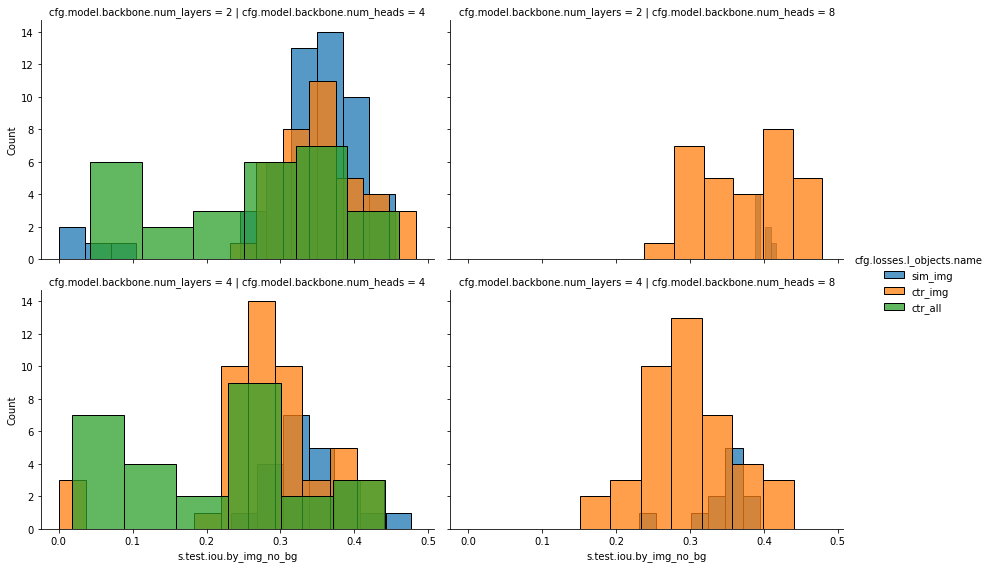

s.vqa.ap


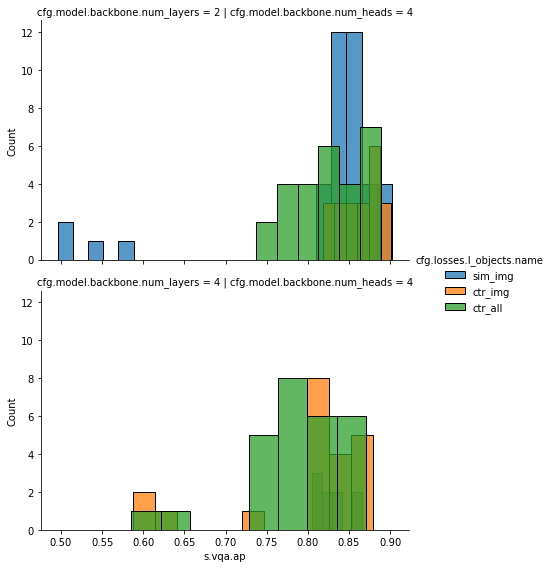

In [7]:
for metric in ["s.test.iou.by_img_no_bg", "s.vqa.ap"]:
    print(metric)
    
    df_tmp = df[
        (df["cfg.model.architecture"] == "backbone-obj_fn(-global_fn-global_proj)-obj_proj")
        # & (df["cfg.model.backbone.patch_size"].map(lambda v: v == [8, 8]))
        # & (df["cfg.model.backbone.embed_dim"] == 64)
        # & (df["cfg.model.backbone.num_layers"] == 2)
        # & (df["cfg.model.backbone.num_heads"] == 4)
        & (df["cfg.data.crop_scale"].map(lambda v: v == [0.3, 1.0]))
        & (df["cfg.model.obj_queries.name"] == "learned")
        & (df["cfg.model.obj_fn.name"] == "slot-attention")
        & (df["cfg.losses.l_objects.name"].isin({"ctr_all", "ctr_img", "sim_img"}))
        & (df["cfg.losses.l_global.weight"] > 0.0)
        & (~df[metric].isna())
    ]

    g = sns.FacetGrid(
        df_tmp,
        col="cfg.model.backbone.num_heads",
        row="cfg.model.backbone.num_layers",
        hue="cfg.losses.l_objects.name",
        height=4,
        aspect=1.5,
    )
    g.map(sns.histplot, metric)
    g.add_legend(title="cfg.losses.l_objects.name")
    plt.show()

s.test.iou.by_img_no_bg


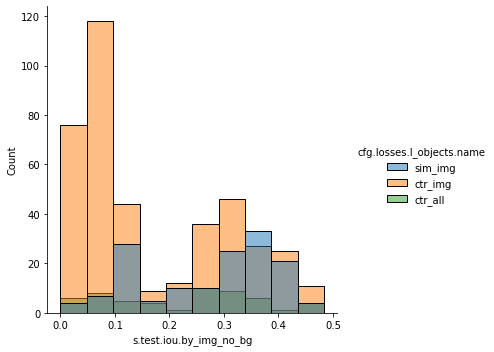

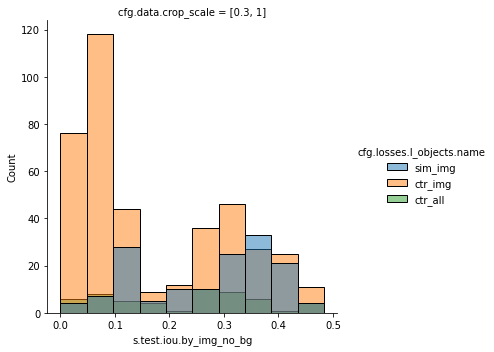

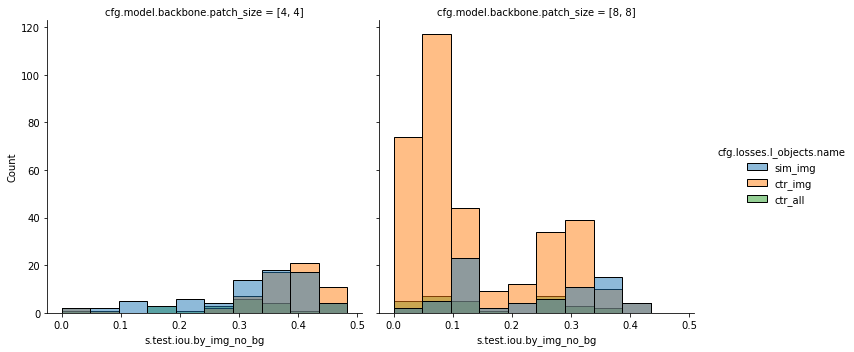

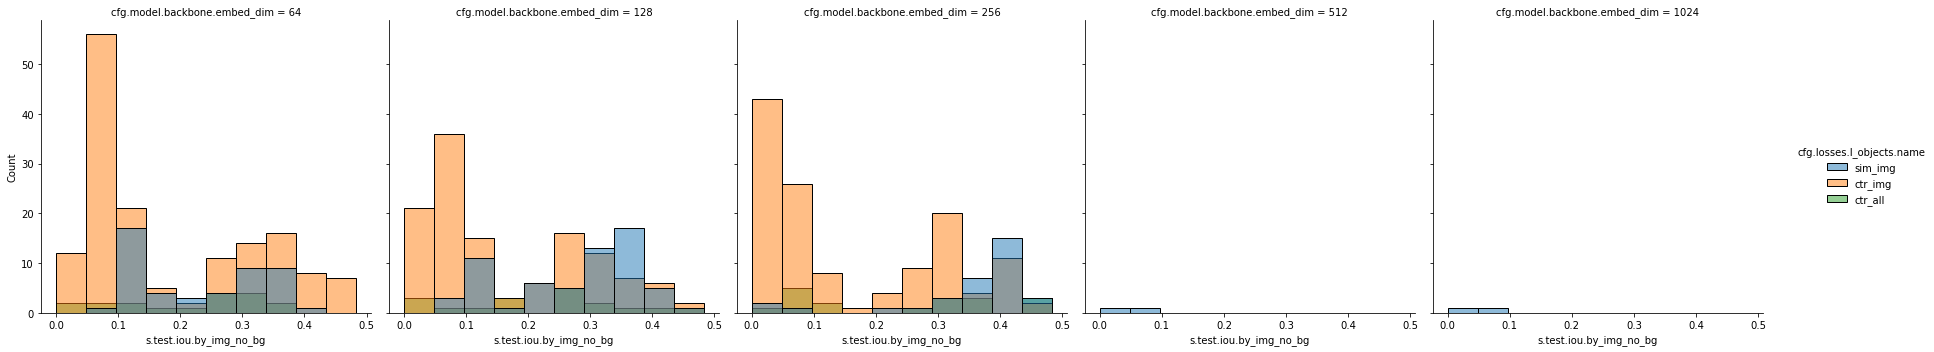

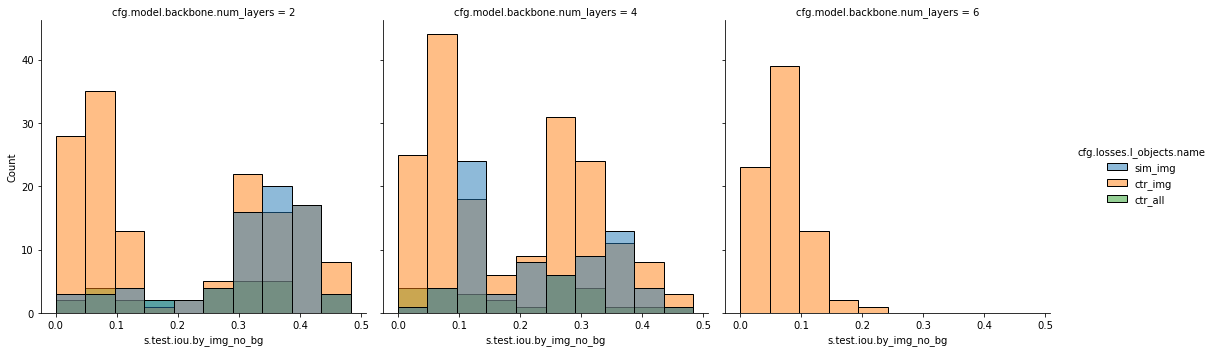

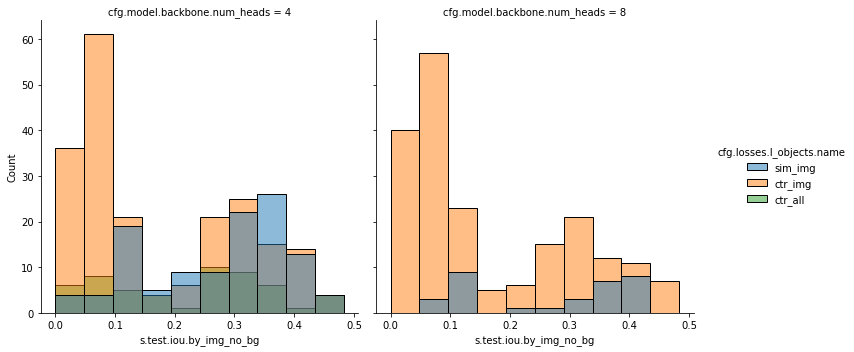

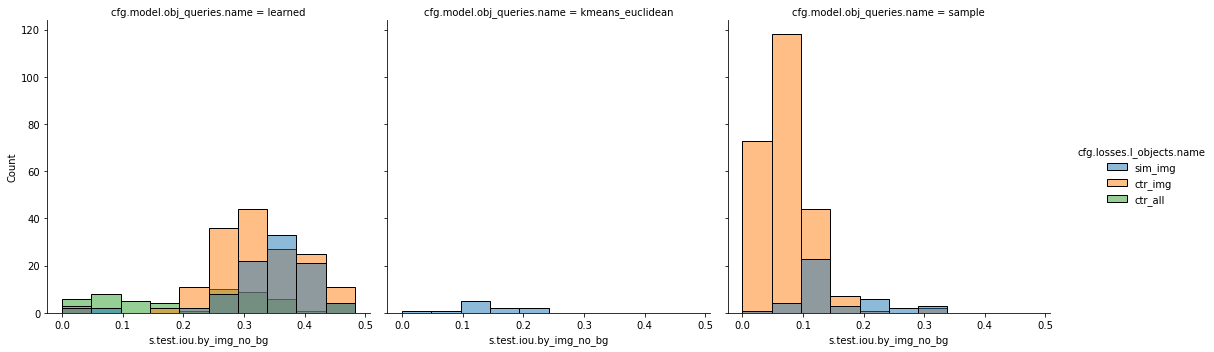

s.vqa.ap


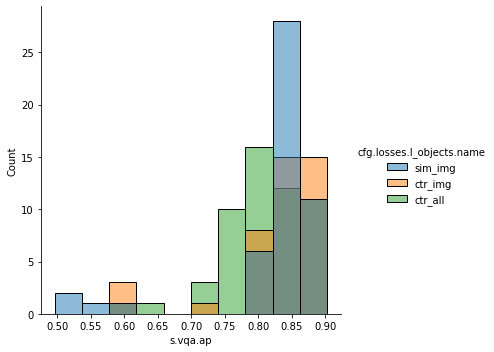

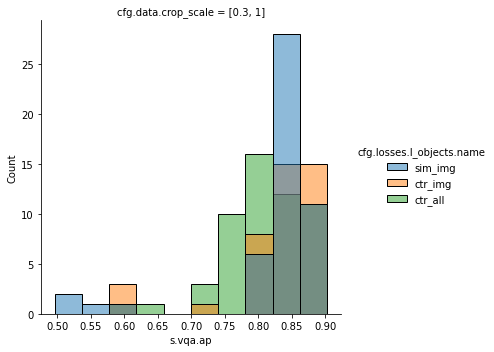

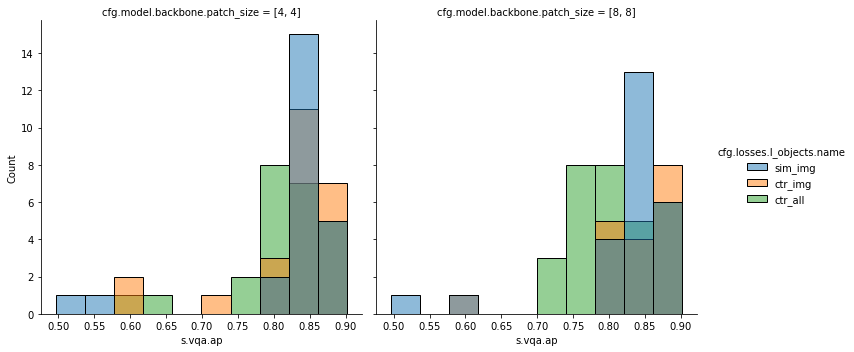

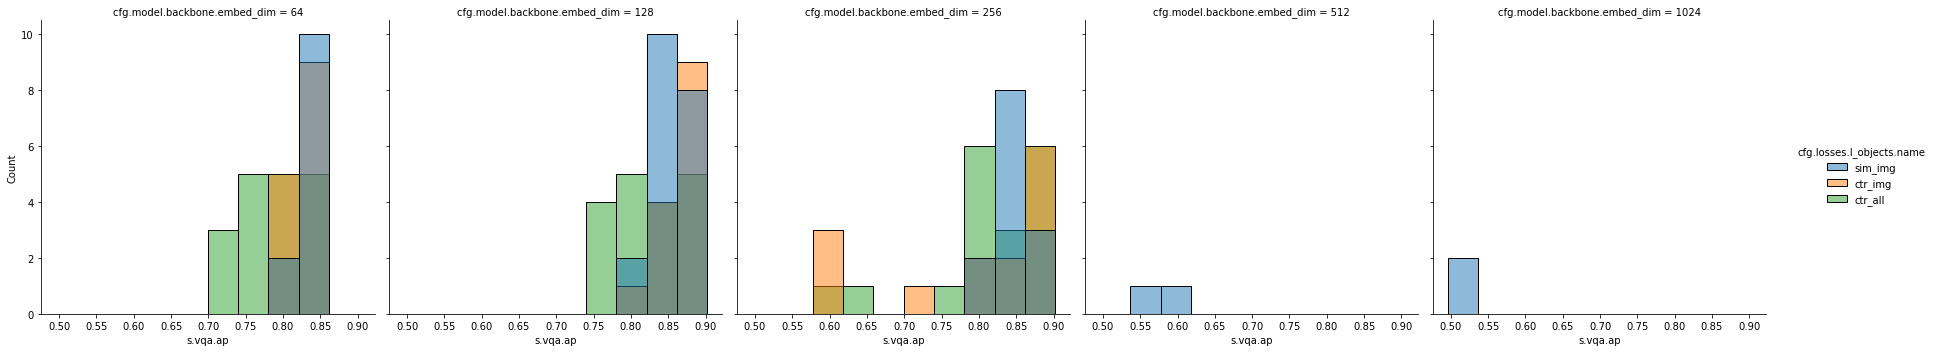

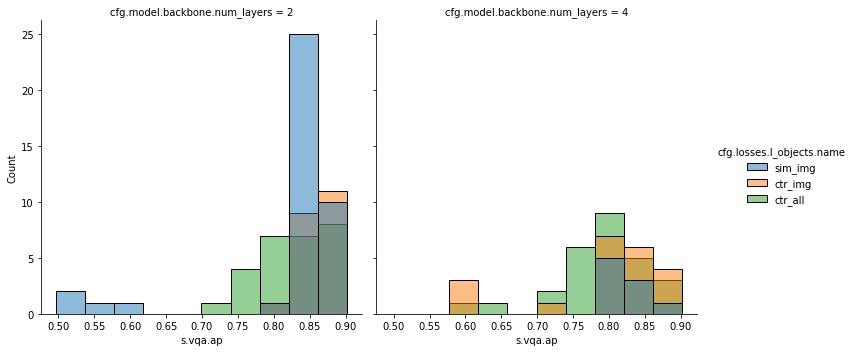

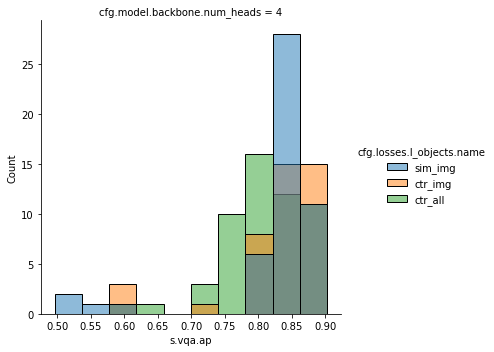

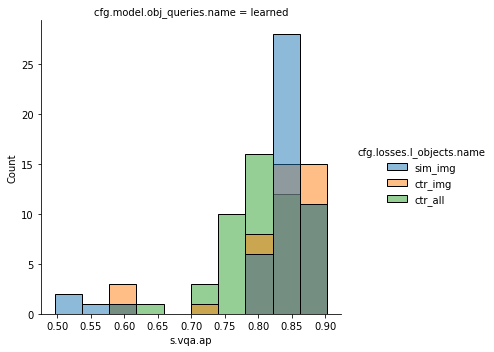

In [8]:
for metric in ["s.test.iou.by_img_no_bg", "s.vqa.ap"]:
    print(metric)

    df_tmp = df[
        (df["cfg.model.architecture"] == "backbone-obj_fn(-global_fn-global_proj)-obj_proj")
        & (df["cfg.model.obj_fn.name"] == "slot-attention")
        & (df["cfg.data.crop_scale"].map(lambda v: v == [0.3, 1.0]))
        & (df["cfg.losses.l_objects.name"].isin({"ctr_all", "ctr_img", "sim_img"}))
        & (df["cfg.losses.l_global.weight"] > 0.0)
        & (~df[metric].isna())
    ]

    df_tmp = df_tmp.copy()
    df_tmp["cfg.data.crop_scale"] = df_tmp["cfg.data.crop_scale"].astype(str)
    df_tmp["cfg.model.backbone.patch_size"] = df_tmp[
        "cfg.model.backbone.patch_size"
    ].astype(str)
    df_tmp.sort_values(
        [
            "cfg.data.crop_scale",
            "cfg.model.backbone.patch_size",
        ],
        inplace=True,
    )

    for col in [
        None,
        "cfg.data.crop_scale",
        "cfg.model.backbone.patch_size",
        "cfg.model.backbone.embed_dim",
        "cfg.model.backbone.num_layers",
        "cfg.model.backbone.num_heads",
        "cfg.model.obj_queries.name",
    ]:
        sns.displot(
            df_tmp,
            x=metric,
            hue="cfg.losses.l_objects.name",
            col=col,
            bins=10,
        )
        plt.show()

## Slot attention vs cross attention

s.test.iou.by_img_no_bg


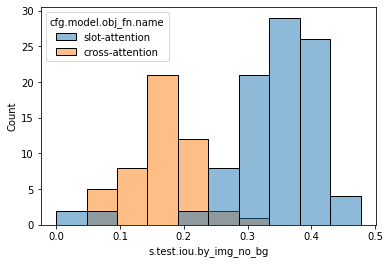

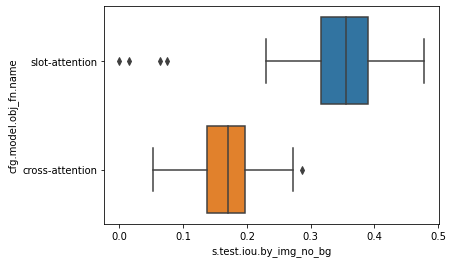

s.vqa.ap


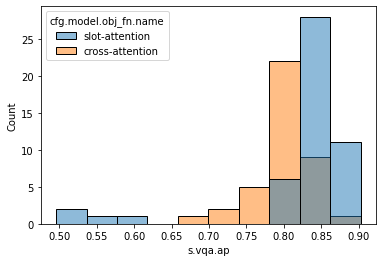

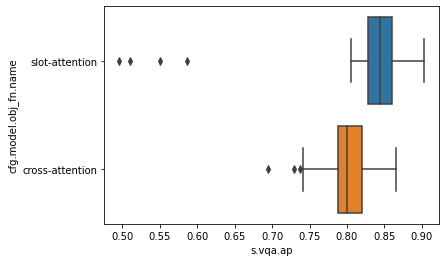

In [9]:
for metric in ["s.test.iou.by_img_no_bg", "s.vqa.ap"]:
    print(metric)

    df_tmp = df[
        (df["cfg.model.architecture"] == "backbone-obj_fn(-global_fn-global_proj)-obj_proj")
        # & (df["cfg.model.backbone.patch_size"].map(lambda v: v == [8, 8]))
        # & (df["cfg.model.backbone.embed_dim"] == 64)
        # & (df["cfg.model.backbone.num_layers"] == 2)
        # & (df["cfg.model.backbone.num_heads"] == 4)
        & (df["cfg.data.crop_scale"].map(lambda v: v == [0.3, 1.0]))
        & (df["cfg.model.obj_queries.name"] == "learned")
        & (df["cfg.model.obj_fn.name"].isin({"slot-attention", "cross-attention"}))
        & (df["cfg.losses.l_objects.name"] == "sim_img")
        & (df["cfg.losses.l_global.weight"] > 0.0)
        & (~df[metric].isna())
    ]


    sns.histplot(df_tmp, x=metric, hue="cfg.model.obj_fn.name", bins=10)
    plt.show()
    sns.boxplot(
        data=df_tmp,
        x=metric,
        y="cfg.model.obj_fn.name",
    )
    plt.show()

s.test.iou.by_img_no_bg


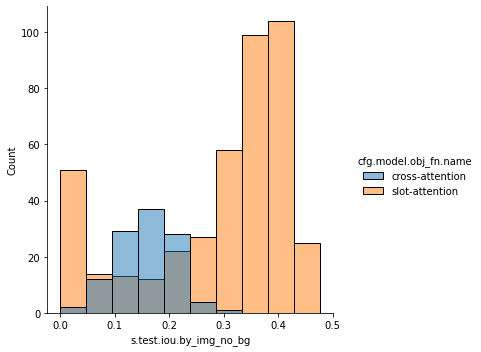

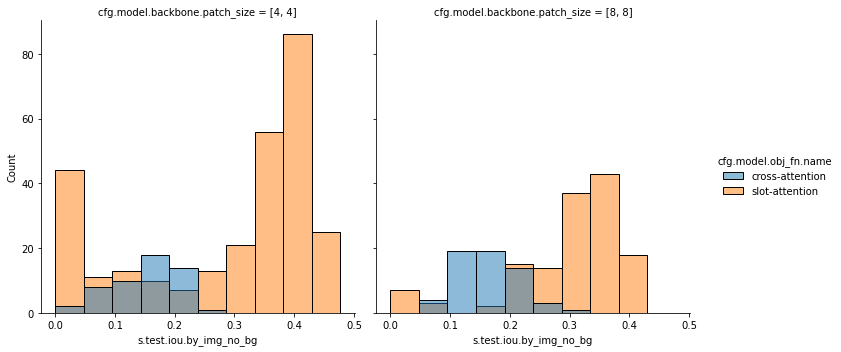

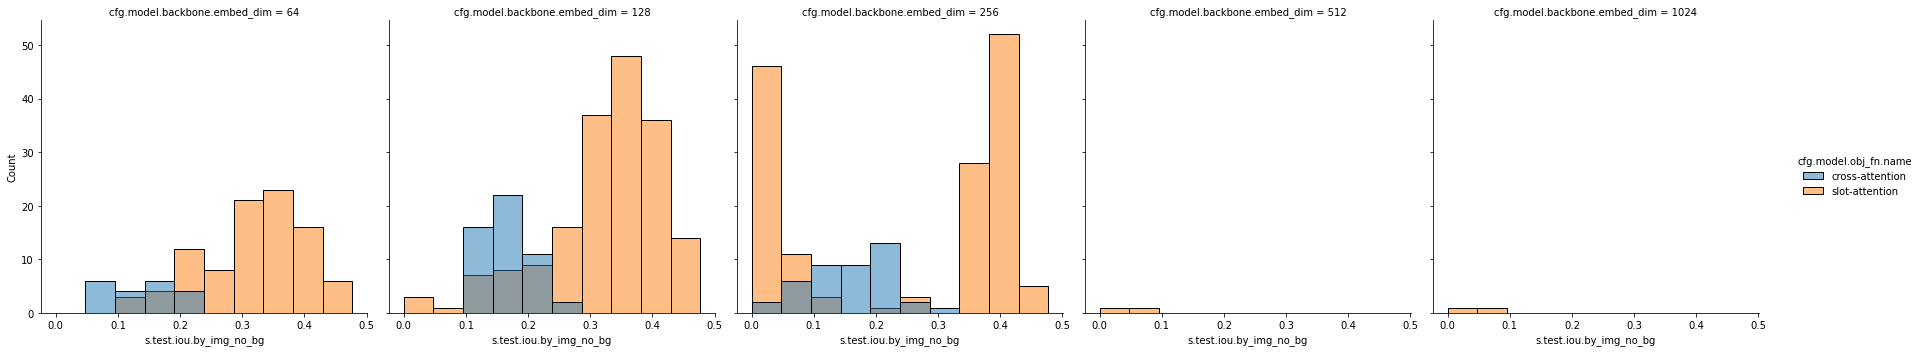

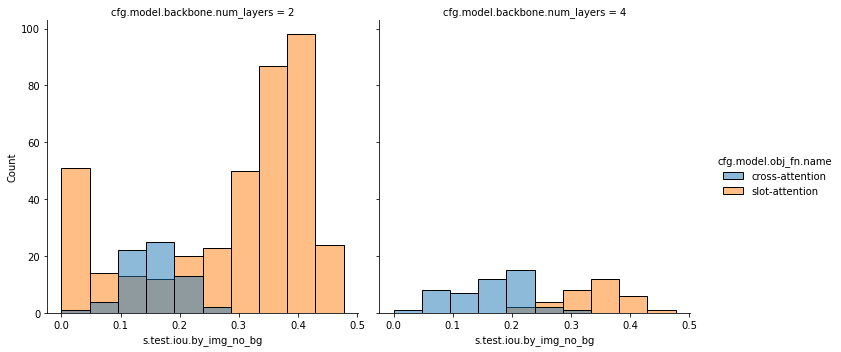

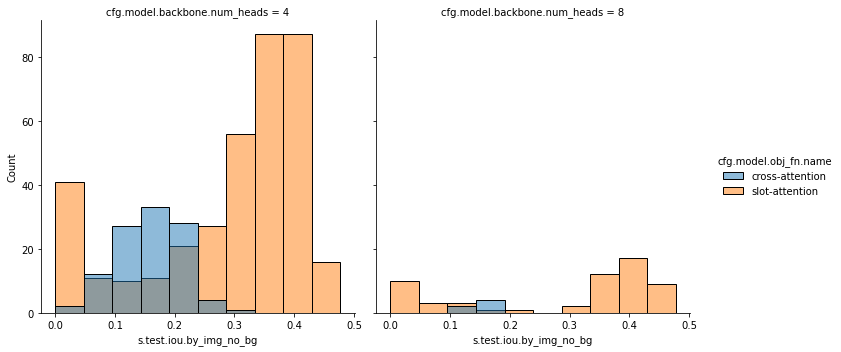

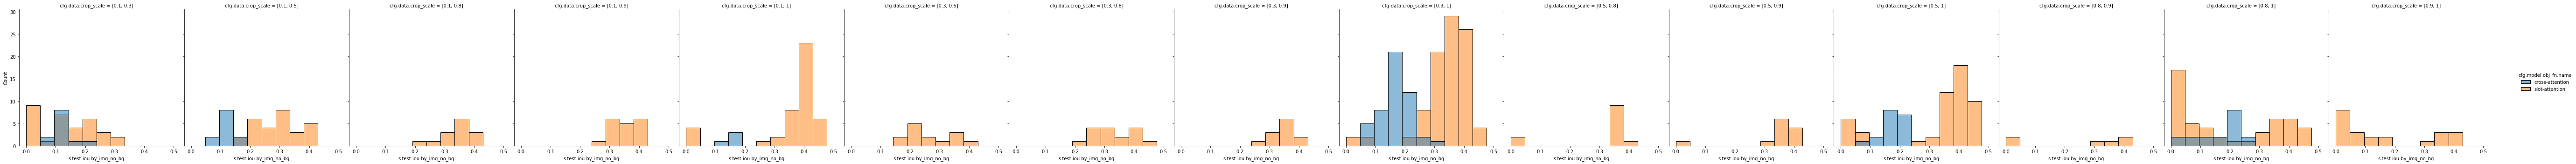

s.vqa.ap


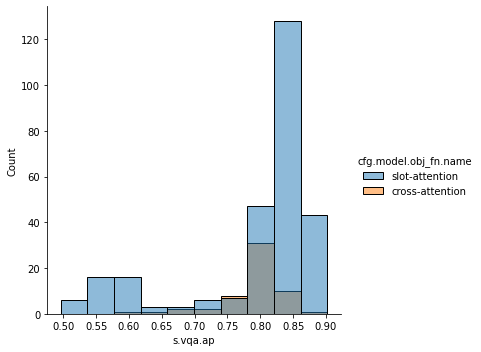

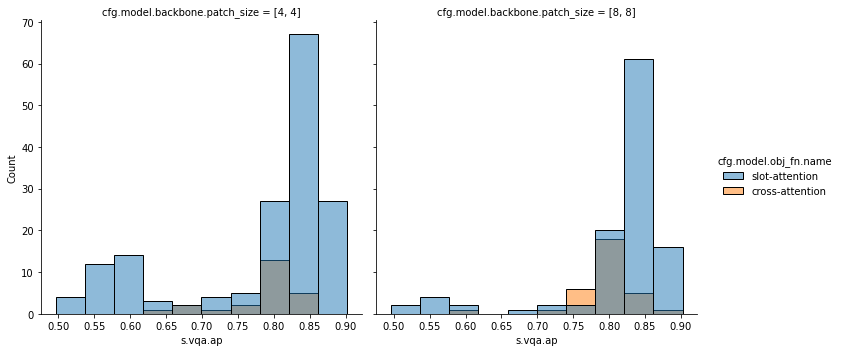

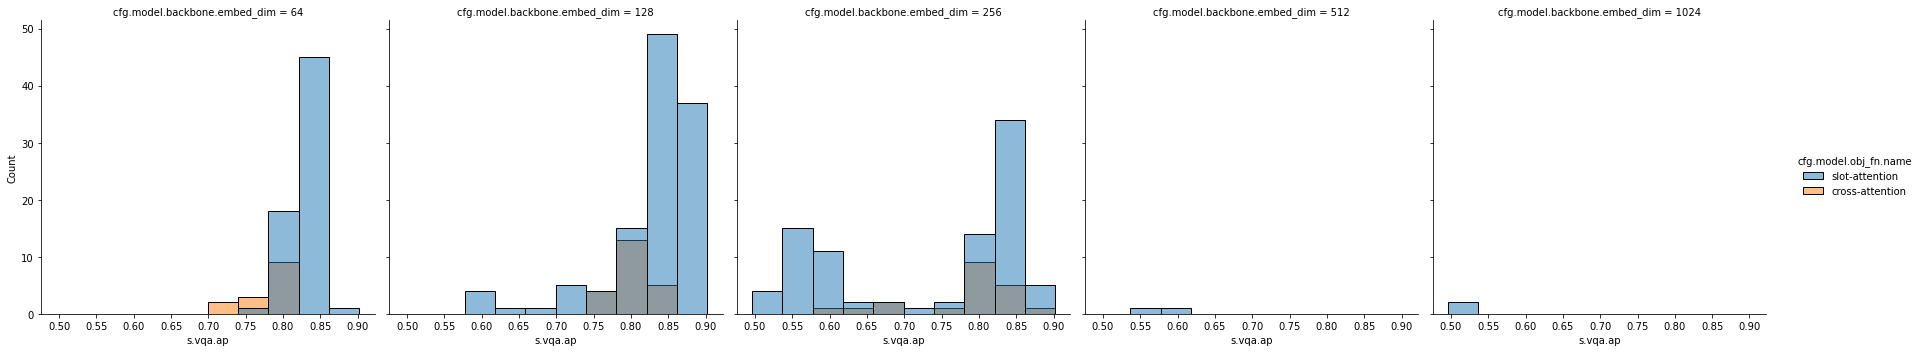

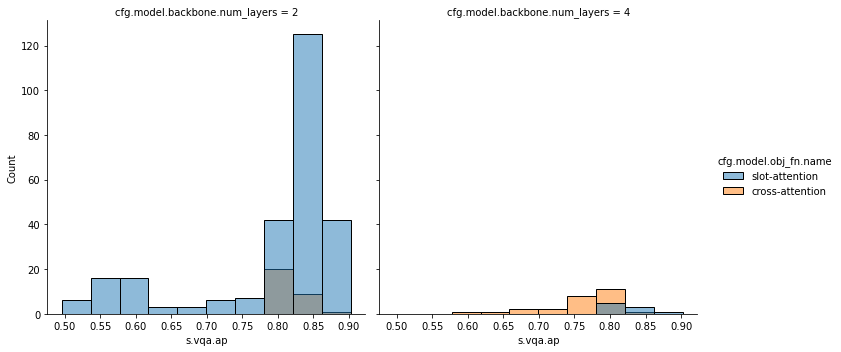

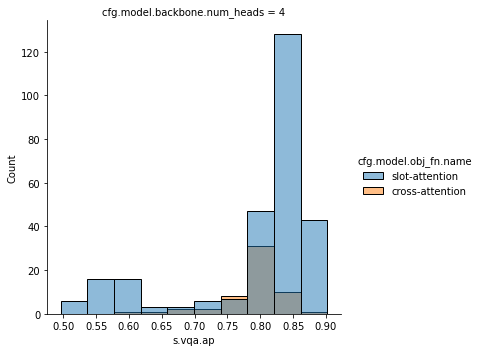

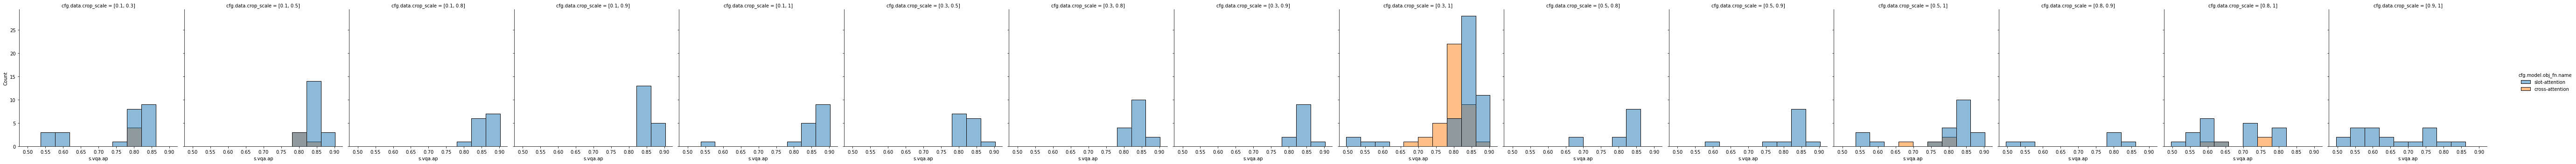

In [10]:
for metric in ["s.test.iou.by_img_no_bg", "s.vqa.ap"]:
    print(metric)

    df_tmp = df[
        (df["cfg.model.architecture"] == "backbone-obj_fn(-global_fn-global_proj)-obj_proj")
        # & (df["cfg.model.backbone.patch_size"].map(lambda v: v == [8, 8]))
        # & (df["cfg.model.backbone.embed_dim"] == 64)
        # & (df["cfg.model.backbone.num_layers"] == 2)
        # & (df["cfg.model.backbone.num_heads"] == 4)
        # & (df["cfg.data.crop_scale"].map(lambda v: v == [0.3, 1.0]))
        & (df["cfg.model.obj_queries.name"] == "learned")
        & (df["cfg.model.obj_fn.name"].isin({"slot-attention", "cross-attention"}))
        & (df["cfg.losses.l_objects.name"] == "sim_img")
        & (df["cfg.losses.l_global.weight"] > 0.0)
        & (~df[metric].isna())
    ]

    df_tmp = df_tmp.copy()
    df_tmp["cfg.model.backbone.patch_size"] = df_tmp[
        "cfg.model.backbone.patch_size"
    ].astype(str)
    df_tmp["cfg.data.crop_scale"] = df_tmp["cfg.data.crop_scale"].astype(str)
    df_tmp.sort_values("cfg.data.crop_scale", inplace=True)

    for col in [
        None,
        "cfg.model.backbone.patch_size",
        "cfg.model.backbone.embed_dim",
        "cfg.model.backbone.num_layers",
        "cfg.model.backbone.num_heads",
        "cfg.data.crop_scale",
    ]:
        sns.displot(
            df_tmp,
            x=metric,
            hue="cfg.model.obj_fn.name",
            col=col,
            bins=10,
        )
        plt.show()

## Crop scale

In [15]:
for metric in ["s.test.iou.by_img_no_bg", "s.vqa.ap"]:
    print(metric)

    df_tmp = df[
        (df["cfg.model.architecture"] == "backbone-obj_fn(-global_fn-global_proj)-obj_proj")
        # & (df["cfg.model.backbone.patch_size"].map(lambda v: v == [8, 8]))
        # & (df["cfg.model.backbone.embed_dim"] == 64)
        # & (df["cfg.model.backbone.num_layers"] == 2)
        # & (df["cfg.model.backbone.num_heads"] == 4)
        # & (df["cfg.data.crop_scale"].map(lambda v: v == [0.3, 1.0]))
        & (df["cfg.model.obj_queries.name"] == "learned")
        & (df["cfg.model.obj_fn.name"] == "slot-attention")
        & (df["cfg.losses.l_objects.name"] == "sim_img")
        & (df["cfg.losses.l_global.weight"] > 0.0)
        & (~df[metric].isna())
    ]

    df_tmp = df_tmp.copy()
    df_tmp["cfg.data.crop_scale.0"] = df_tmp["cfg.data.crop_scale"].map(
        lambda v: int(100 * v[0])
    )
    df_tmp["cfg.data.crop_scale.1"] = df_tmp["cfg.data.crop_scale"].map(
        lambda v: int(100 * v[1])
    )
    df_tmp["cfg.data.crop_scale"] = df_tmp["cfg.data.crop_scale"].astype(str)
    df_tmp.sort_values("cfg.data.crop_scale", inplace=True)

    # sns.histplot(
    #     data=df_tmp, x="s.test.iou.by_img_no_bg", hue="cfg.data.crop_scale", bins=10
    # )
    # plt.show()
    # sns.boxplot(
    #     data=df_tmp,
    #     x="s.test.iou.by_img_no_bg",
    #     y="cfg.data.crop_scale",
    # )
    # plt.show()

    display(
        df_tmp.groupby(["cfg.data.crop_scale.0", "cfg.data.crop_scale.1"])[metric]
        .size()
        .rename_axis(["min", "max"])
        .to_frame()
        .pivot_table(values=metric, index="min", columns="max")
        .style.set_caption(
            f"Count of runs with a given (min, max) crop scale parameters"
        )
        .background_gradient(axis=None)
        .highlight_null('white')
        .format("{:.0f}", na_rep="")
    )
    display(
        df_tmp.groupby(["cfg.data.crop_scale.0", "cfg.data.crop_scale.1"])[metric]
        .max()
        .rename_axis(["min", "max"])
        .to_frame()
        .pivot_table(values=metric, index="min", columns="max")
        .style.set_caption(
            f"Max '{metric}' of all runs with a given (min, max) crop scale parameters"
        )
        .background_gradient(axis=None)
        .highlight_null('white')
        .format(lambda v: f"{100*v:.1f}", na_rep="")
    )
    display(
        df_tmp.groupby(["cfg.data.crop_scale.0", "cfg.data.crop_scale.1"])[metric]
        .mean()
        .rename_axis(["min", "max"])
        .to_frame()
        .pivot_table(values=metric, index="min", columns="max")
        .style.set_caption(
            f"Average '{metric}' of all runs with a given (min, max) crop scale parameters"
        )
        .background_gradient(axis=None)
        .highlight_null('white')
        .format(lambda v: f"{100*v:.1f}", na_rep="")
    )

s.test.iou.by_img_no_bg


max,30,50,80,90,100
min,,,,,
10,32,28,14,18,44
30,,14,16,12,94
50,,,12,12,52
80,,,,6,49
90,,,,,22


max,30,50,80,90,100
min,,,,,
10,31.7,40.1,41.3,42.7,46.7
30,,38.6,43.0,40.7,47.7
50,,,38.8,41.3,46.6
80,,,,42.9,44.9
90,,,,,39.8


max,30,50,80,90,100
min,,,,,
10,13.7,29.1,34.0,35.5,35.9
30,,26.3,32.9,34.8,34.0
50,,,30.3,34.6,33.2
80,,,,25.1,19.0
90,,,,,15.4


s.vqa.ap


max,30,50,80,90,100
min,,,,,
10,24,20,14,18,16
30,,14,16,12,49
50,,,12,12,22
80,,,,6,20
90,,,,,20


max,30,50,80,90,100
min,,,,,
10,85.4,87.3,89.0,88.9,90.1
30,,86.3,88.5,87.6,90.2
50,,,85.9,86.4,86.9
80,,,,82.7,80.2
90,,,,,82.7


max,30,50,80,90,100
min,,,,,
10,75.9,84.0,86.0,85.5,84.5
30,,82.9,83.7,83.8,82.2
50,,,80.6,81.5,78.7
80,,,,72.1,66.1
90,,,,,65.3


## Patch size

s.test.iou.by_img_no_bg


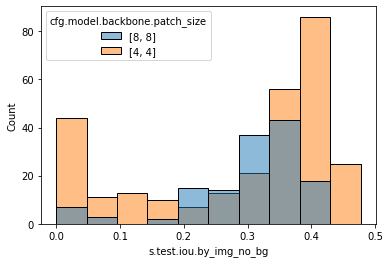

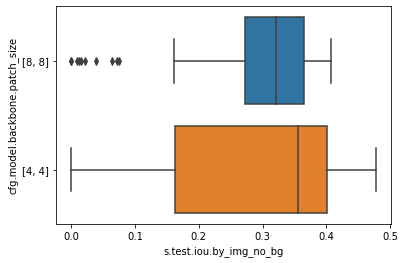

s.vqa.ap


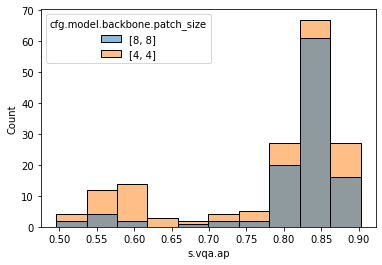

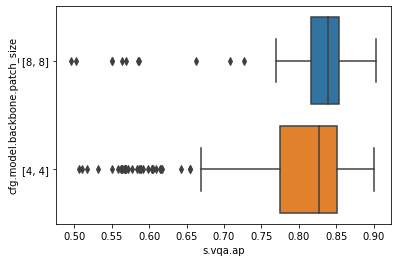

In [12]:
for metric in ["s.test.iou.by_img_no_bg", "s.vqa.ap"]:
    print(metric)

    df_tmp = df[
        (df["cfg.model.architecture"] == "backbone-obj_fn(-global_fn-global_proj)-obj_proj")
        # & (df["cfg.model.backbone.patch_size"].map(lambda v: v == [8, 8]))
        # & (df["cfg.model.backbone.embed_dim"] == 64)
        # & (df["cfg.model.backbone.num_layers"] == 2)
        # & (df["cfg.model.backbone.num_heads"] == 4)
        # & (df["cfg.data.crop_scale"].map(lambda v: v == [0.3, 1.0]))
        & (df["cfg.model.obj_queries.name"] == "learned")
        & (df["cfg.model.obj_fn.name"] == "slot-attention")
        & (df["cfg.losses.l_objects.name"] == "sim_img")
        & (df["cfg.losses.l_global.weight"] > 0.0)
        & (~df[metric].isna())
    ]

    df_tmp = df_tmp.copy()
    df_tmp["cfg.model.backbone.patch_size"] = df_tmp[
        "cfg.model.backbone.patch_size"
    ].astype(str)
    df_tmp["cfg.data.crop_scale"] = df_tmp["cfg.data.crop_scale"].astype(str)
    df_tmp.sort_values("cfg.data.crop_scale", inplace=True)

    sns.histplot(
        data=df_tmp,
        x=metric,
        hue="cfg.model.backbone.patch_size",
        bins=10,
    )
    plt.show()
    sns.boxplot(
        data=df_tmp,
        x=metric,
        y="cfg.model.backbone.patch_size",
    )
    plt.show()

s.test.iou.by_img_no_bg


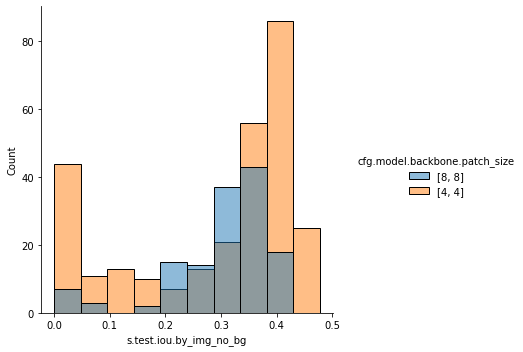

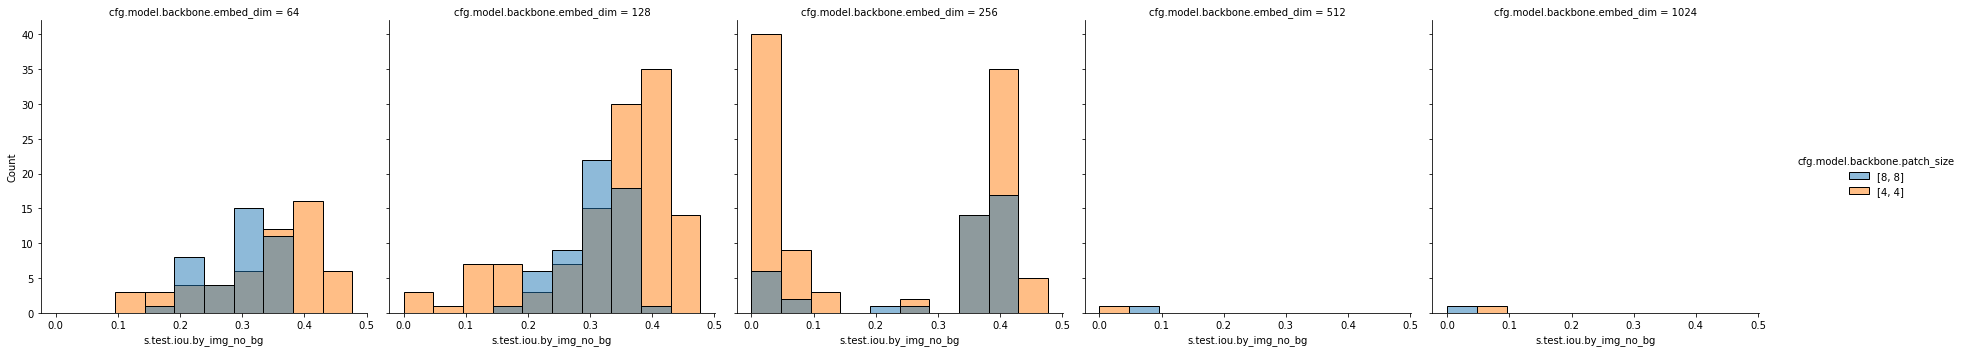

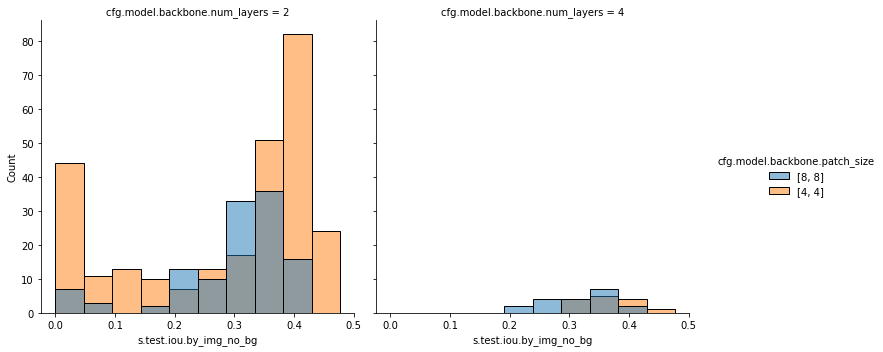

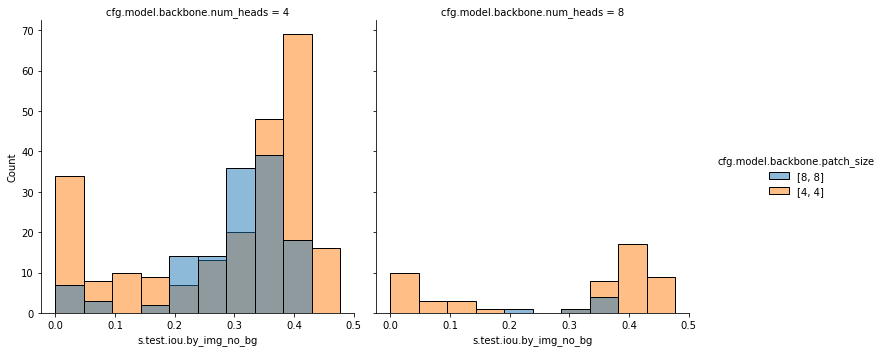

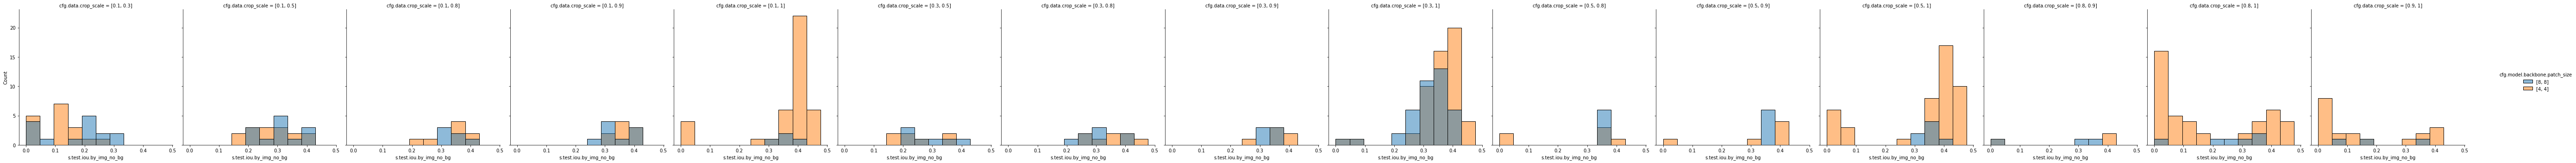

s.vqa.ap


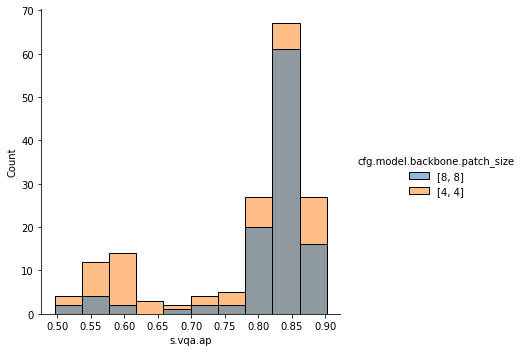

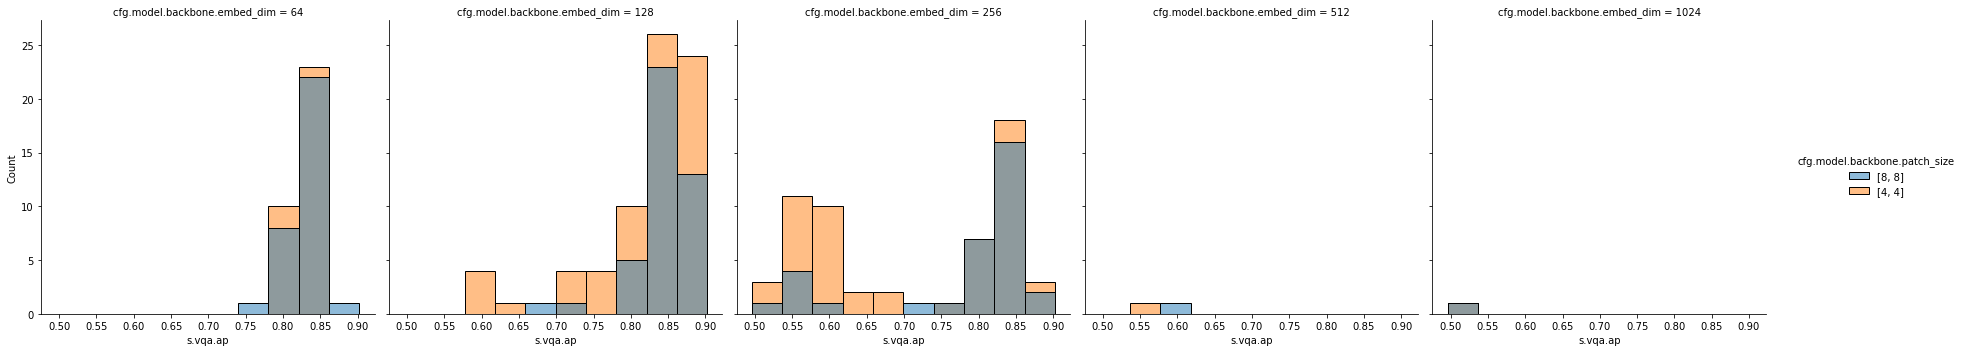

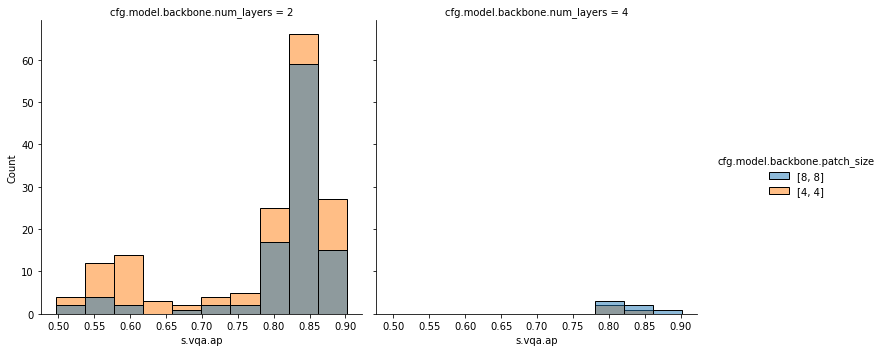

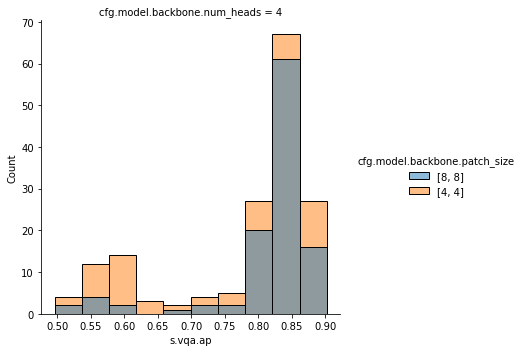

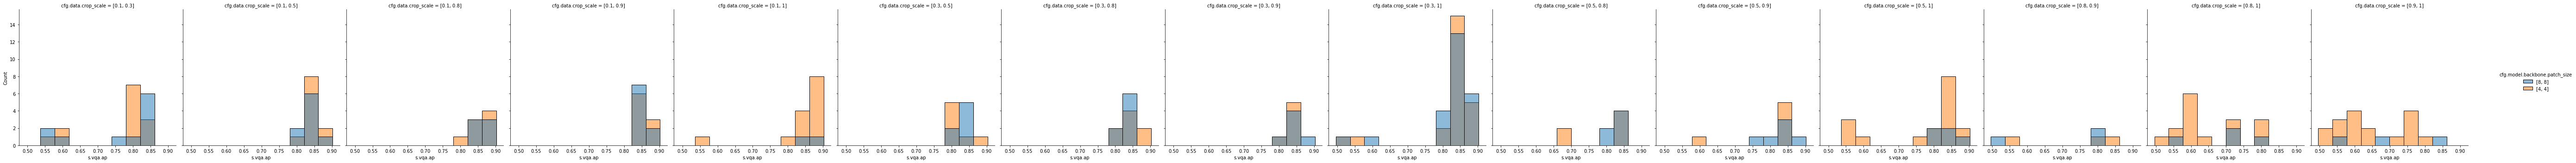

In [13]:
for metric in ["s.test.iou.by_img_no_bg", "s.vqa.ap"]:
    print(metric)

    df_tmp = df[
        (df["cfg.model.architecture"] == "backbone-obj_fn(-global_fn-global_proj)-obj_proj")
        # & (df["cfg.model.backbone.patch_size"].map(lambda v: v == [8, 8]))
        # & (df["cfg.model.backbone.embed_dim"] == 64)
        # & (df["cfg.model.backbone.num_layers"] == 2)
        # & (df["cfg.model.backbone.num_heads"] == 4)
        # & (df["cfg.data.crop_scale"].map(lambda v: v == [0.3, 1.0]))
        & (df["cfg.model.obj_queries.name"] == "learned")
        & (df["cfg.model.obj_fn.name"] == "slot-attention")
        & (df["cfg.losses.l_objects.name"] == "sim_img")
        & (df["cfg.losses.l_global.weight"] > 0.0)
        & (~df[metric].isna())
    ]

    df_tmp = df_tmp.copy()
    df_tmp["cfg.model.backbone.patch_size"] = df_tmp[
        "cfg.model.backbone.patch_size"
    ].astype(str)
    df_tmp["cfg.data.crop_scale"] = df_tmp["cfg.data.crop_scale"].astype(str)
    df_tmp.sort_values("cfg.data.crop_scale", inplace=True)

    for col in [
        None,
        "cfg.model.backbone.embed_dim",
        "cfg.model.backbone.num_layers",
        "cfg.model.backbone.num_heads",
        "cfg.data.crop_scale",
    ]:
        sns.displot(
            df_tmp,
            x=metric,
            hue="cfg.model.backbone.patch_size",
            col=col,
            bins=10,
        )
        plt.show()

## Object queries

s.test.iou.by_img_no_bg


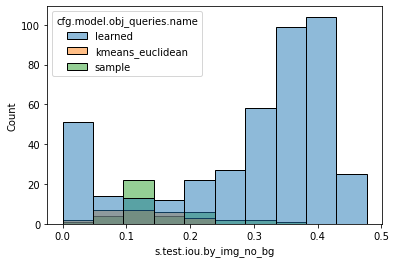

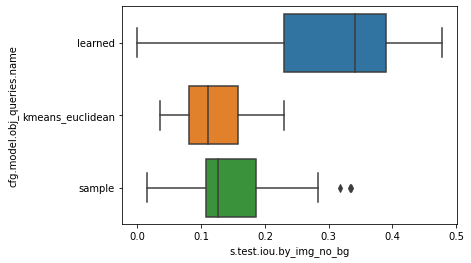

s.vqa.ap


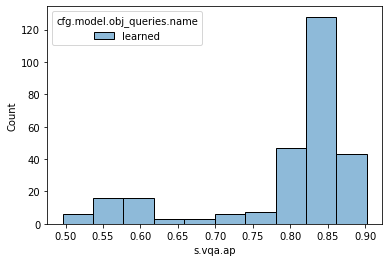

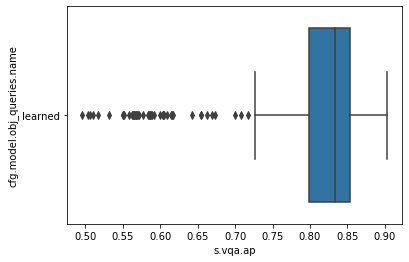

In [14]:
for metric in ["s.test.iou.by_img_no_bg", "s.vqa.ap"]:
    print(metric)

    df_tmp = df[
        (df["cfg.model.architecture"] == "backbone-obj_fn(-global_fn-global_proj)-obj_proj")
        # & (df["cfg.model.backbone.patch_size"].map(lambda v: v == [8, 8]))
        # & (df["cfg.model.backbone.embed_dim"] == 64)
        # & (df["cfg.model.backbone.num_layers"] == 2)
        # & (df["cfg.model.backbone.num_heads"] == 4)
        # & (df["cfg.data.crop_scale"].map(lambda v: v == [0.3, 1.0]))
        & (df["cfg.model.obj_fn.name"] == "slot-attention")
        & (df["cfg.losses.l_objects.name"] == "sim_img")
        & (df["cfg.losses.l_global.weight"] > 0.0)
        & (~df[metric].isna())
    ]

    sns.histplot(
        data=df_tmp, x=metric, hue="cfg.model.obj_queries.name", bins=10
    )
    plt.show()
    sns.boxplot(
        data=df_tmp,
        x=metric,
        y="cfg.model.obj_queries.name",
    )
    plt.show()

s.test.iou.by_img_no_bg


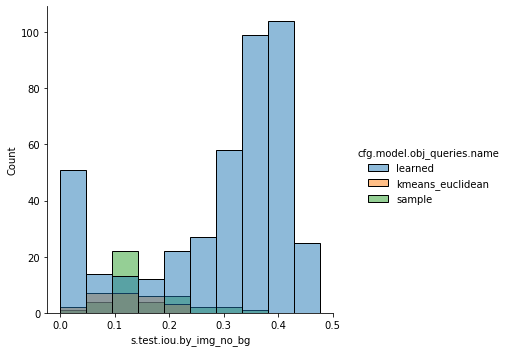

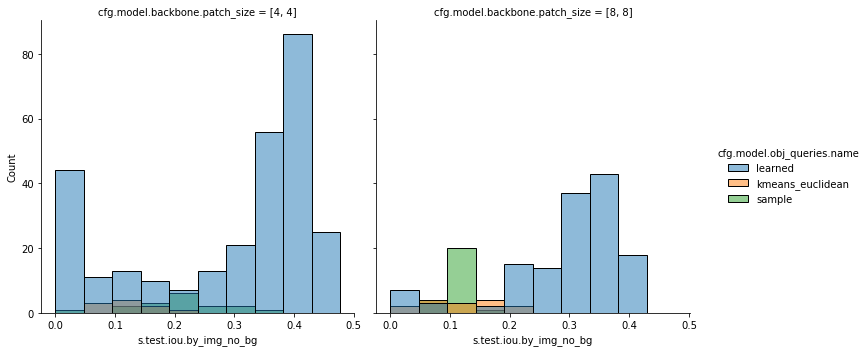

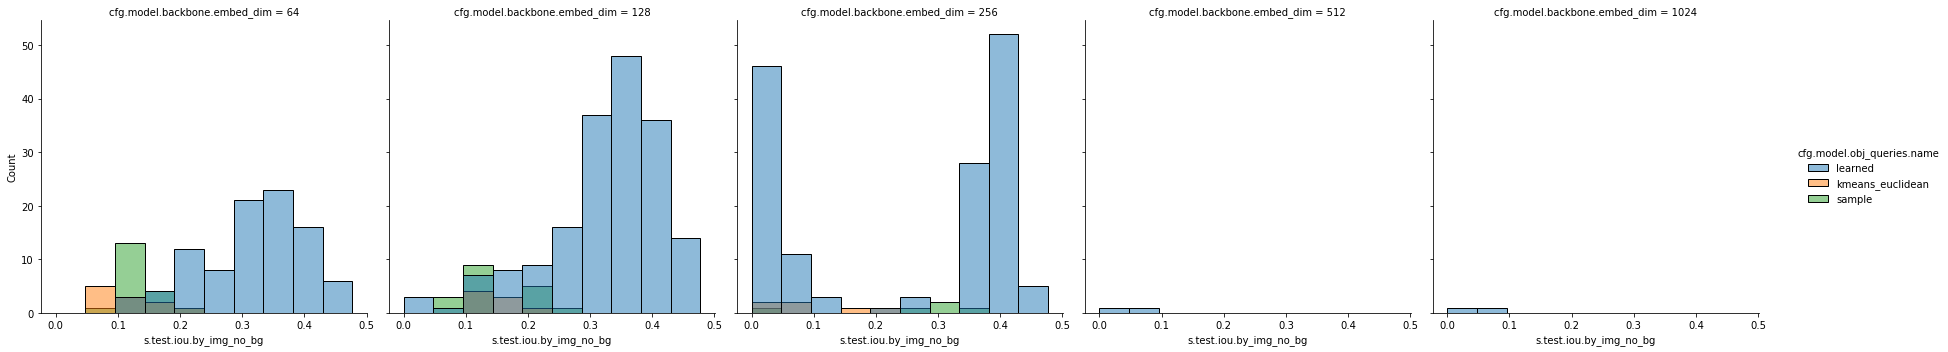

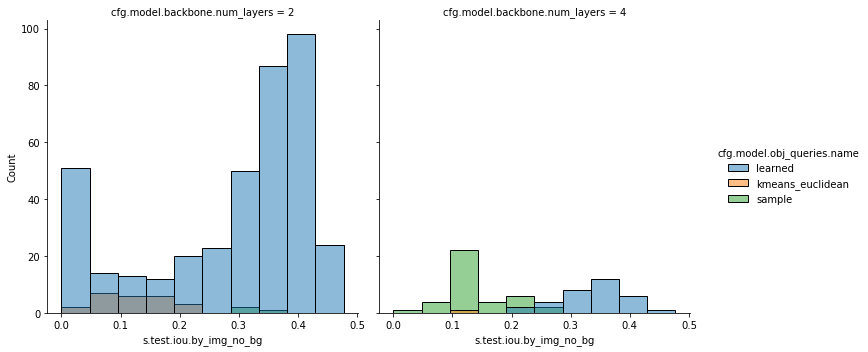

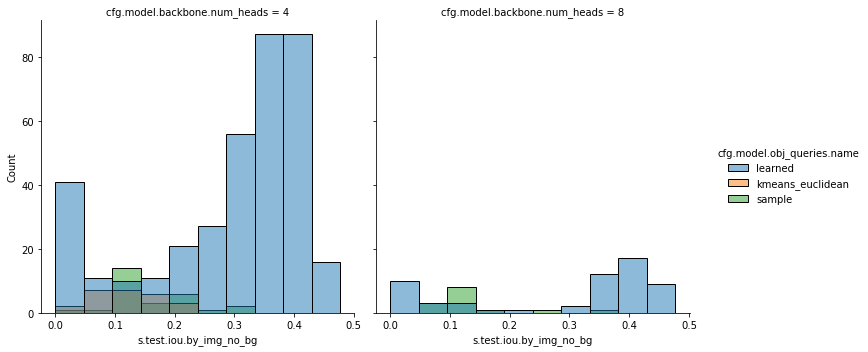

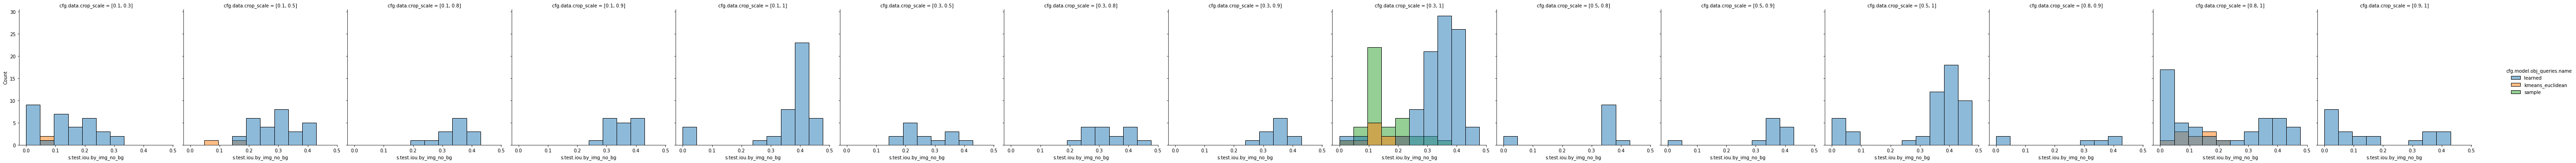

s.vqa.ap


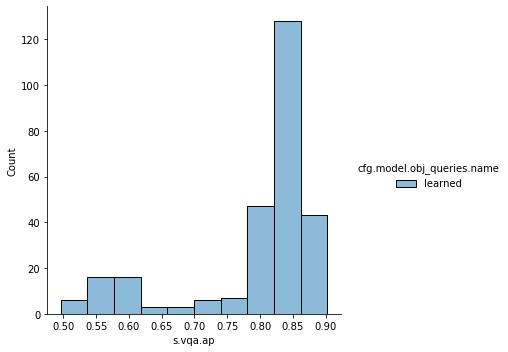

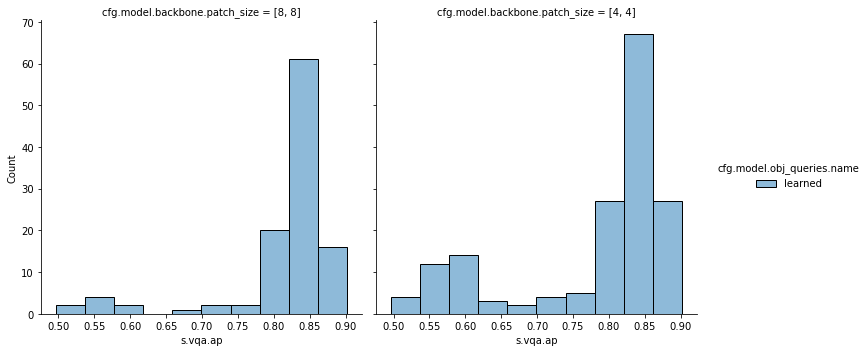

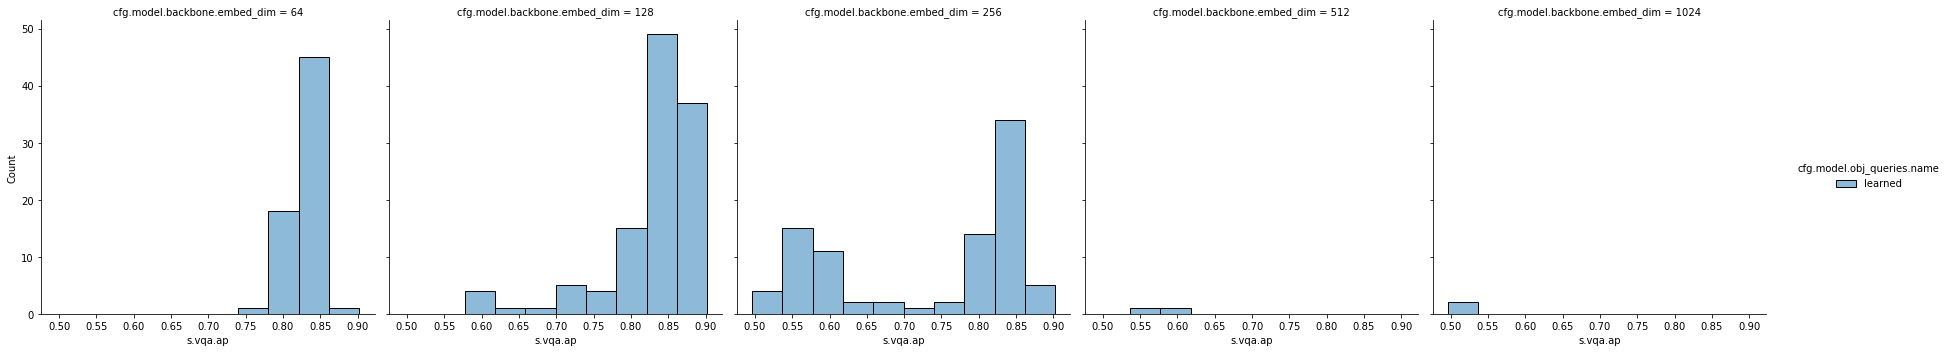

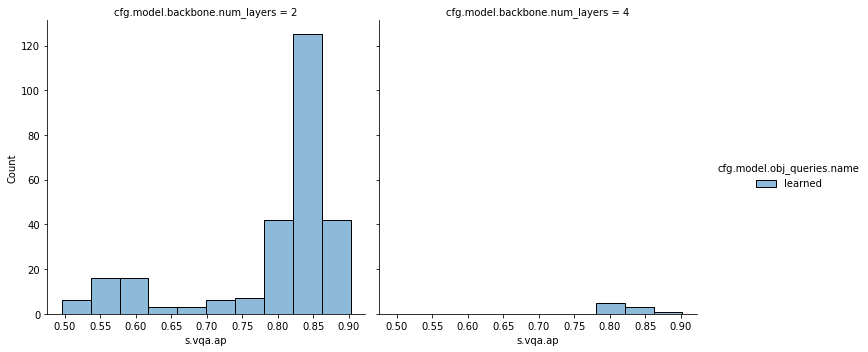

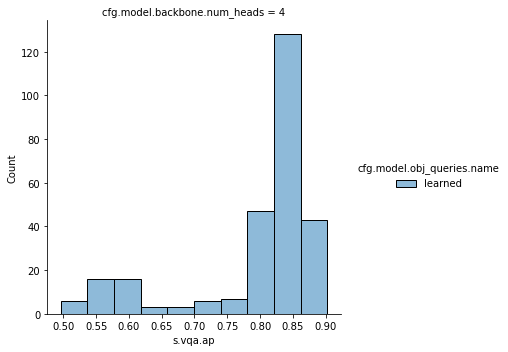

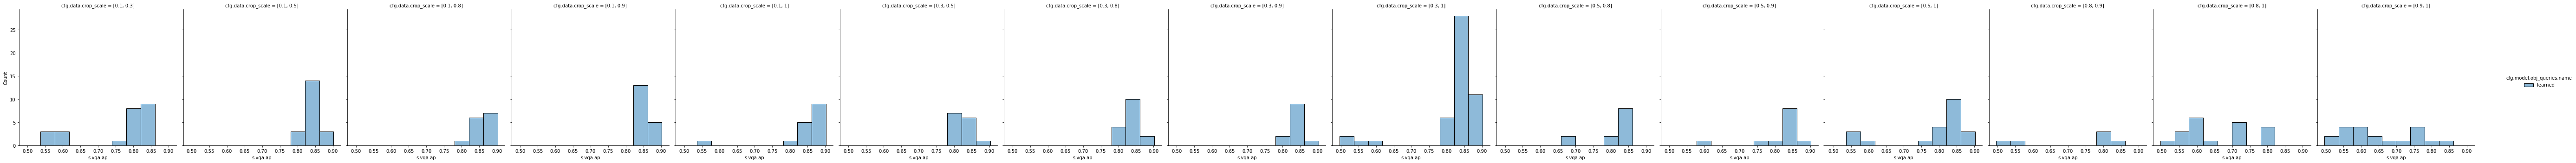

In [15]:
for metric in ["s.test.iou.by_img_no_bg", "s.vqa.ap"]:
    print(metric)

    df_tmp = df[
        (df["cfg.model.architecture"] == "backbone-obj_fn(-global_fn-global_proj)-obj_proj")
        # & (df["cfg.model.backbone.patch_size"].map(lambda v: v == [8, 8]))
        # & (df["cfg.model.backbone.embed_dim"] == 64)
        # & (df["cfg.model.backbone.num_layers"] == 2)
        # & (df["cfg.model.backbone.num_heads"] == 4)
        # & (df["cfg.data.crop_scale"].map(lambda v: v == [0.3, 1.0]))
        & (df["cfg.model.obj_fn.name"] == "slot-attention")
        & (df["cfg.losses.l_objects.name"] == "sim_img")
        & (df["cfg.losses.l_global.weight"] > 0.0)
        & (~df[metric].isna())
    ]

    df_tmp = df_tmp.copy()
    df_tmp["cfg.model.backbone.patch_size"] = df_tmp[
        "cfg.model.backbone.patch_size"
    ].astype(str)
    df_tmp["cfg.data.crop_scale"] = df_tmp["cfg.data.crop_scale"].astype(str)
    df_tmp.sort_values("cfg.data.crop_scale", inplace=True)

    for col in [
        None,
        "cfg.model.backbone.patch_size",
        "cfg.model.backbone.embed_dim",
        "cfg.model.backbone.num_layers",
        "cfg.model.backbone.num_heads",
        "cfg.data.crop_scale",
    ]:
        sns.displot(
            df_tmp,
            x=metric,
            hue="cfg.model.obj_queries.name",
            col=col,
            bins=10,
        )
        plt.show()

## Num heads

s.test.iou.by_img_no_bg


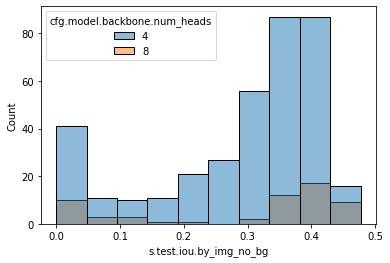

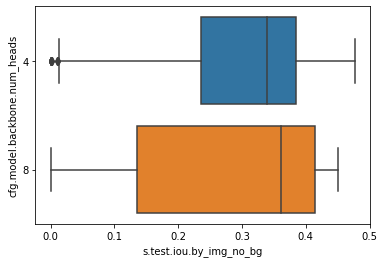

s.vqa.ap


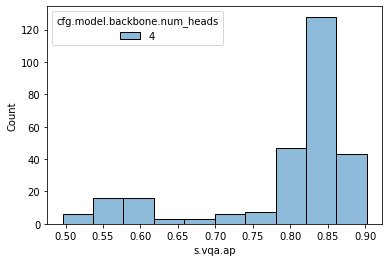

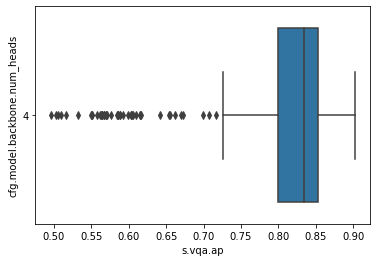

In [16]:
for metric in ["s.test.iou.by_img_no_bg", "s.vqa.ap"]:
    print(metric)

    df_tmp = df[
        (df["cfg.model.architecture"] == "backbone-obj_fn(-global_fn-global_proj)-obj_proj")
        # & (df["cfg.model.backbone.patch_size"].map(lambda v: v == [8, 8]))
        # & (df["cfg.model.backbone.embed_dim"] == 64)
        # & (df["cfg.model.backbone.num_layers"] == 2)
        # & (df["cfg.model.backbone.num_heads"] == 4)
        # & (df["cfg.data.crop_scale"].map(lambda v: v == [0.3, 1.0]))
        & (df["cfg.model.obj_queries.name"] == "learned")
        & (df["cfg.model.obj_fn.name"] == "slot-attention")
        & (df["cfg.losses.l_objects.name"] == "sim_img")
        & (df["cfg.losses.l_global.weight"] > 0.0)
        & (~df[metric].isna())
    ]

    df_tmp = df_tmp.copy()
    df_tmp["cfg.model.backbone.num_heads"] = df_tmp["cfg.model.backbone.num_heads"].astype(
        str
    )

    sns.histplot(
        data=df_tmp,
        x=metric,
        hue="cfg.model.backbone.num_heads",
        bins=10,
    )
    plt.show()
    sns.boxplot(
        data=df_tmp,
        x=metric,
        y="cfg.model.backbone.num_heads",
    )
    plt.show()

s.test.iou.by_img_no_bg


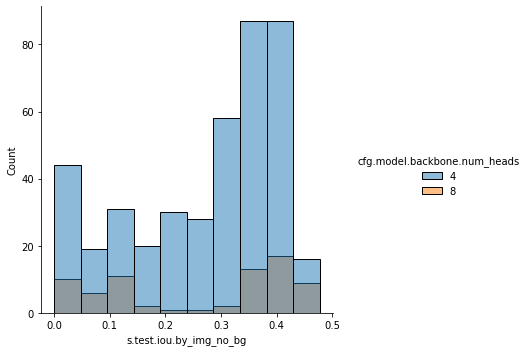

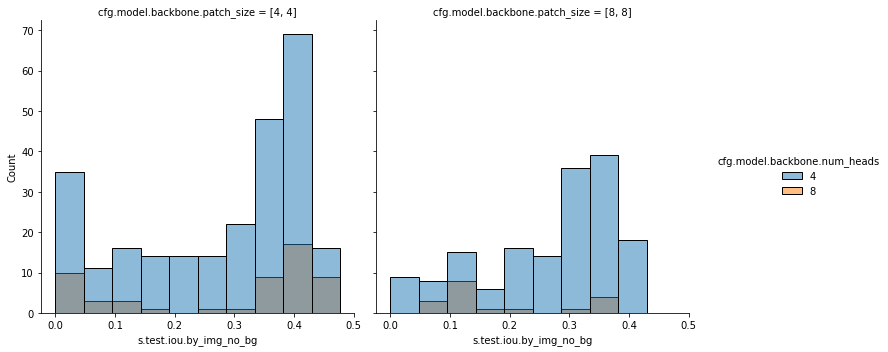

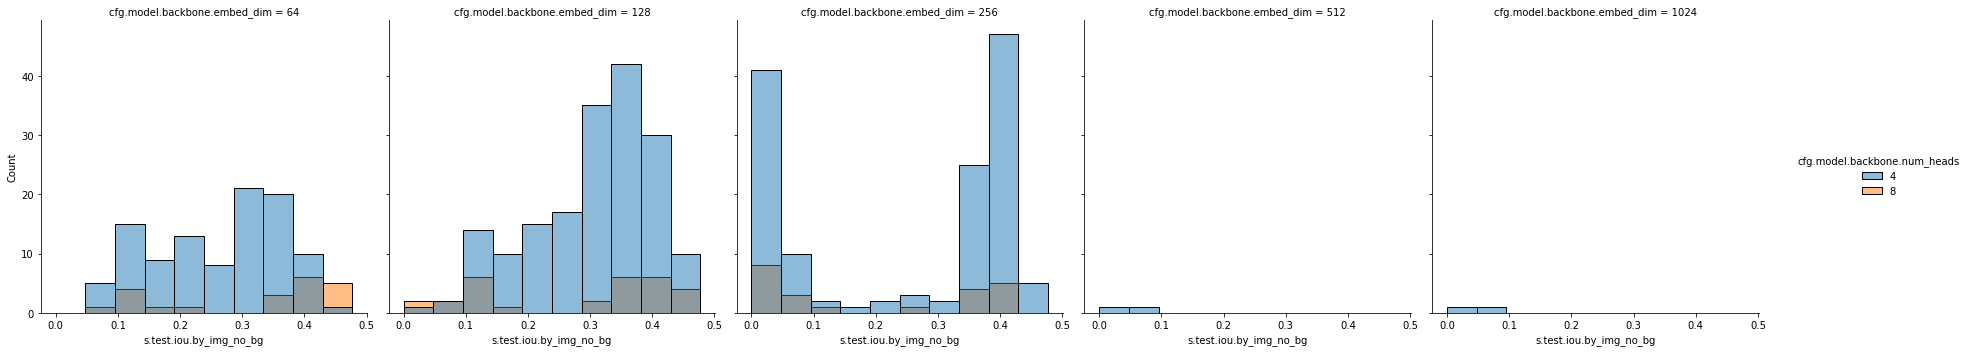

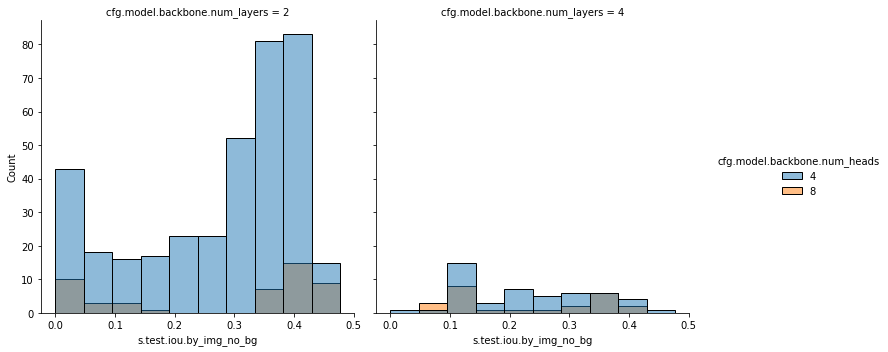

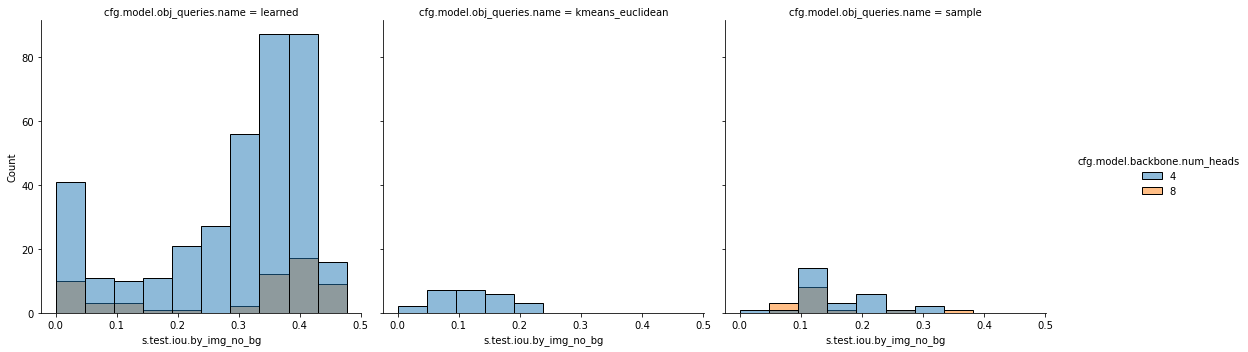

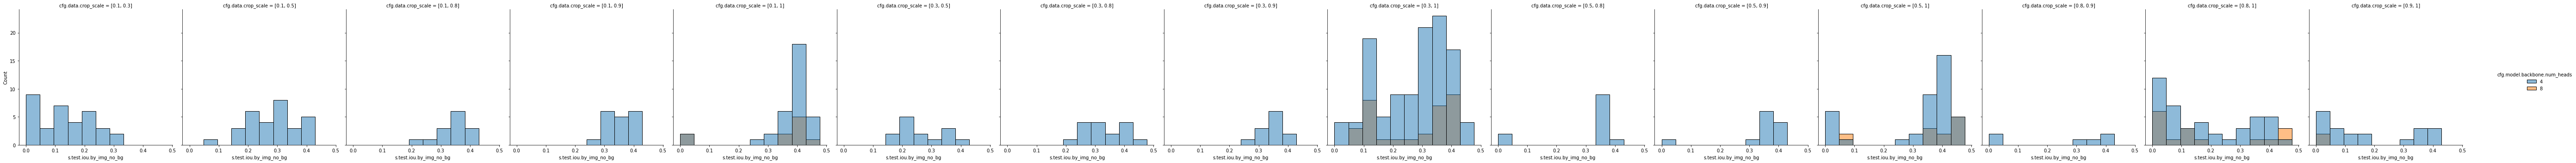

s.vqa.ap


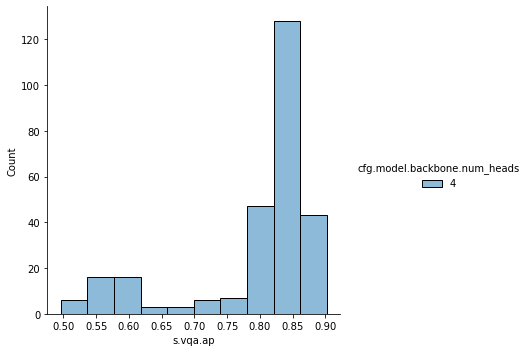

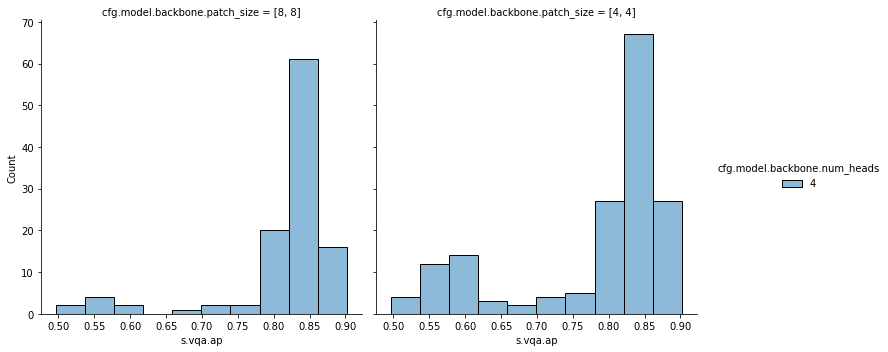

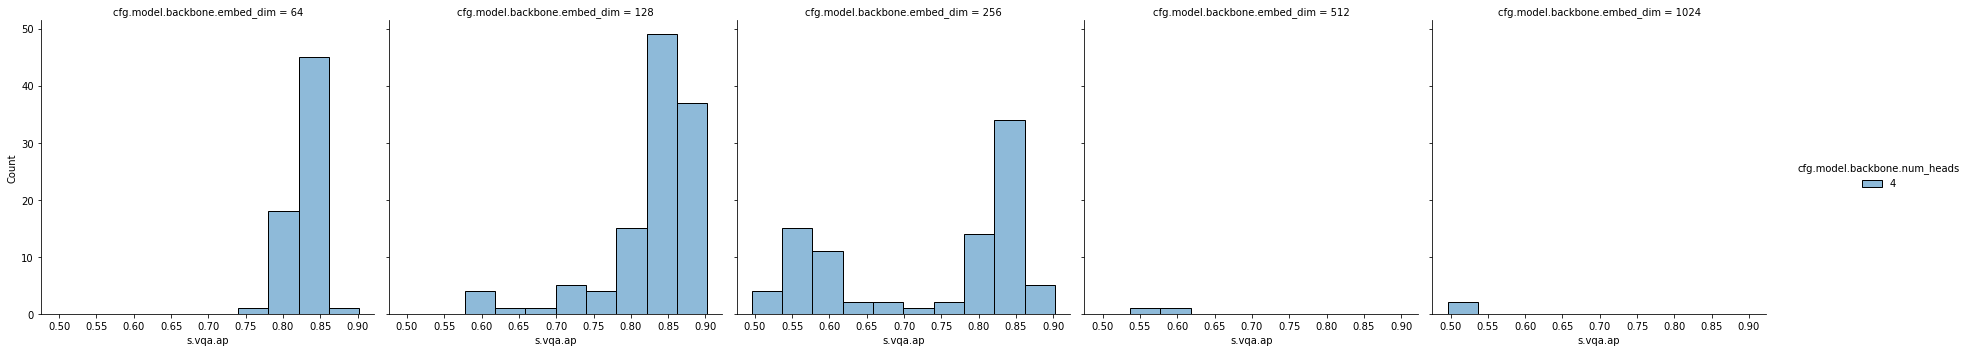

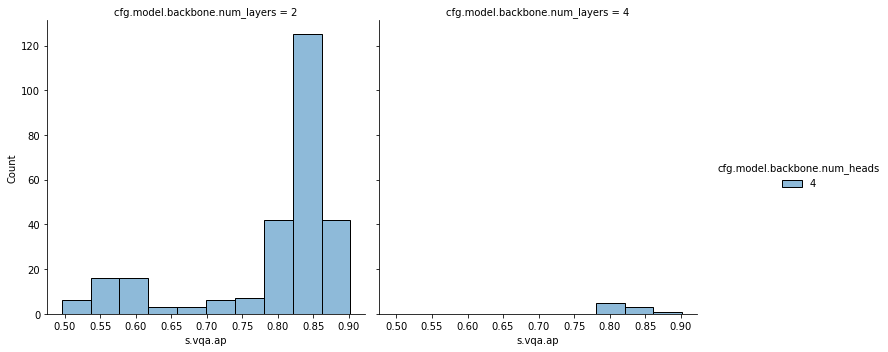

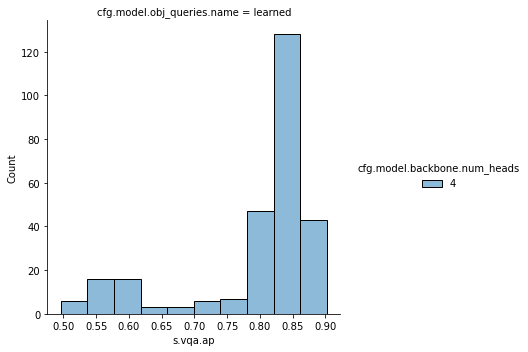

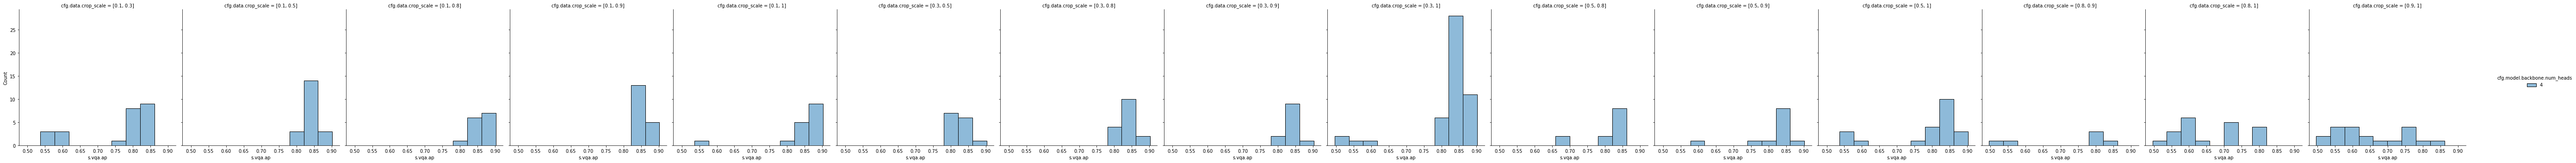

In [17]:
for metric in ["s.test.iou.by_img_no_bg", "s.vqa.ap"]:
    print(metric)

    df_tmp = df[
        (df["cfg.model.architecture"] == "backbone-obj_fn(-global_fn-global_proj)-obj_proj")
        # & (df["cfg.model.backbone.patch_size"].map(lambda v: v == [8, 8]))
        # & (df["cfg.model.backbone.embed_dim"] == 64)
        # & (df["cfg.model.backbone.num_layers"] == 2)
        # & (df["cfg.model.backbone.num_heads"] == 4)
        # & (df["cfg.data.crop_scale"].map(lambda v: v == [0.3, 1.0]))
        # & (df["cfg.model.obj_queries.name"] == "learned")
        & (df["cfg.model.obj_fn.name"] == "slot-attention")
        & (df["cfg.losses.l_objects.name"] == "sim_img")
        & (df["cfg.losses.l_global.weight"] > 0.0)
        & (~df[metric].isna())
    ]

    df_tmp = df_tmp.copy()
    df_tmp["cfg.model.backbone.patch_size"] = df_tmp[
        "cfg.model.backbone.patch_size"
    ].astype(str)
    df_tmp["cfg.data.crop_scale"] = df_tmp["cfg.data.crop_scale"].astype(str)
    df_tmp.sort_values("cfg.data.crop_scale", inplace=True)
    df_tmp["cfg.model.backbone.num_heads"] = df_tmp["cfg.model.backbone.num_heads"].astype(
        str
    )

    for col in [
        None,
        "cfg.model.backbone.patch_size",
        "cfg.model.backbone.embed_dim",
        "cfg.model.backbone.num_layers",
        "cfg.model.obj_queries.name",
        "cfg.data.crop_scale",
    ]:
        sns.displot(
            df_tmp,
            x=metric,
            hue="cfg.model.backbone.num_heads",
            col=col,
            bins=10,
        )
        plt.show()

## Global-only architecture

s.vqa.ap


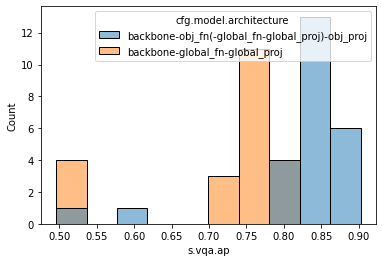

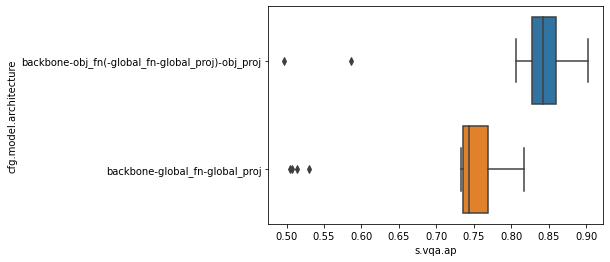

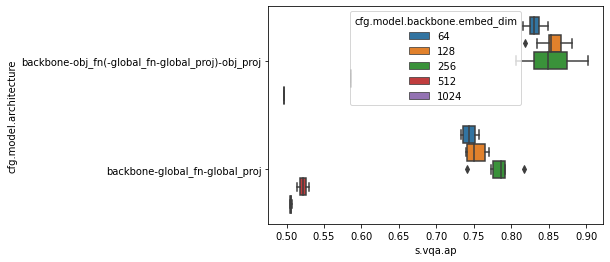

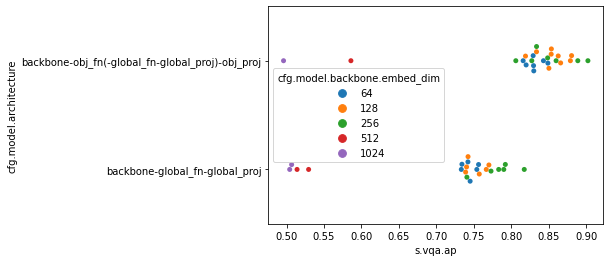

s.vqa.auroc


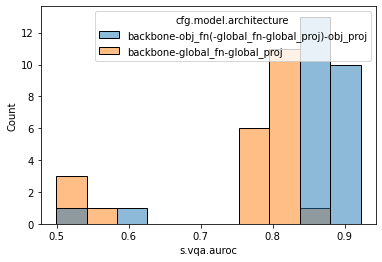

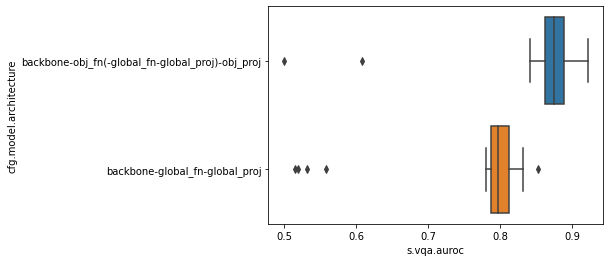

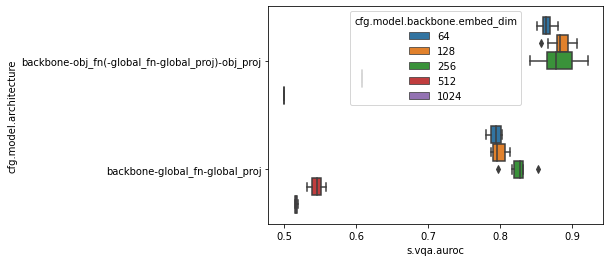

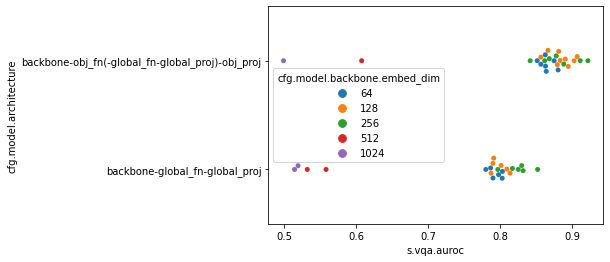

In [18]:
for metric in ["s.vqa.ap", "s.vqa.auroc"]:
    print(metric)

    df_tmp = df[
        (~df[metric].isna())
        & (df["cfg.data.crop_scale"].map(lambda v: v == [0.3, 1.0]))
        & (df["cfg.model.backbone.patch_size"].map(lambda v: v == [8, 8]))
        # & (df["cfg.model.backbone.embed_dim"] == 64)
        # & (df["cfg.model.backbone.num_layers"] == 2)
        # & (df["cfg.model.backbone.num_heads"] == 4)
        & (
            (
                (df["cfg.model.architecture"] == "backbone-global_fn-global_proj")
            )
            | (
                (df["cfg.model.architecture"] == "backbone-obj_fn(-global_fn-global_proj)-obj_proj")
                & (df["cfg.model.obj_queries.name"] == "learned")
                & (df["cfg.model.obj_fn.name"] == "slot-attention")
                & (df["cfg.losses.l_objects.name"] == "sim_img")
                & (df["cfg.losses.l_global.weight"] > 0.0)
            )
        )
    ]

    df_tmp = df_tmp.copy()
    df_tmp = df_tmp.copy()
    df_tmp["cfg.model.backbone.patch_size"] = df_tmp["cfg.model.backbone.patch_size"].astype(str)
    df_tmp["cfg.data.crop_scale"] = df_tmp["cfg.data.crop_scale"].astype(str)
    df_tmp.sort_values("cfg.data.crop_scale", inplace=True)

    sns.histplot(
        data=df_tmp,
        x=metric,
        hue="cfg.model.architecture",
        bins=10,
    )
    plt.show()
    sns.boxplot(
        data=df_tmp,
        x=metric,
        y="cfg.model.architecture",
    )
    plt.show()
    
    sns.boxplot(
        data=df_tmp,
        x=metric,
        y="cfg.model.architecture",
        hue="cfg.model.backbone.embed_dim",
    )
    plt.show()

    sns.swarmplot(
        data=df_tmp,
        x=metric,
        y="cfg.model.architecture",
        hue="cfg.model.backbone.embed_dim",
    )
    plt.show()

s.vqa.ap


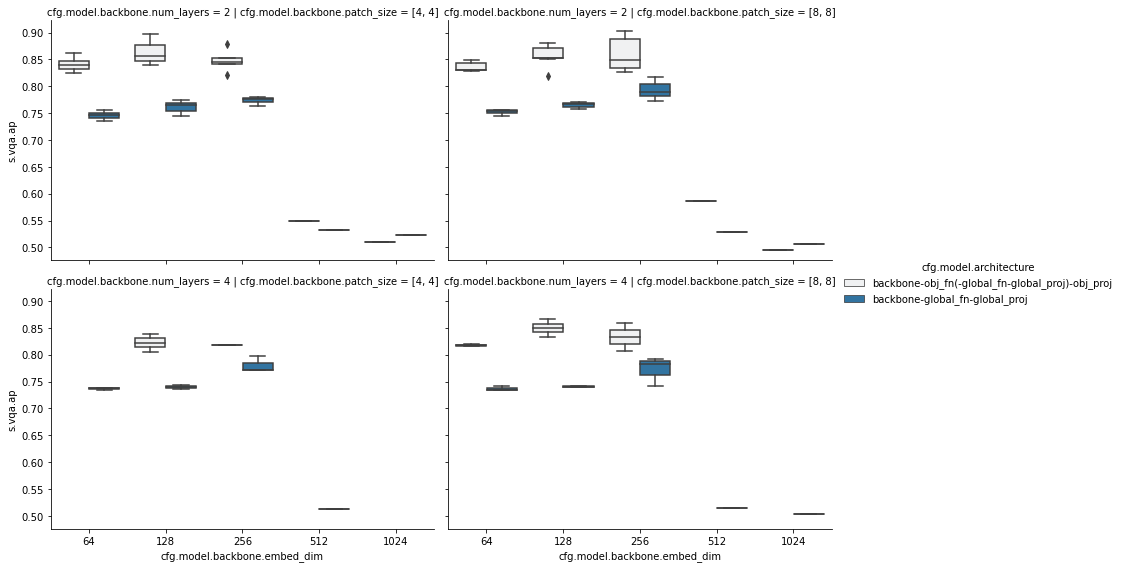

s.vqa.auroc


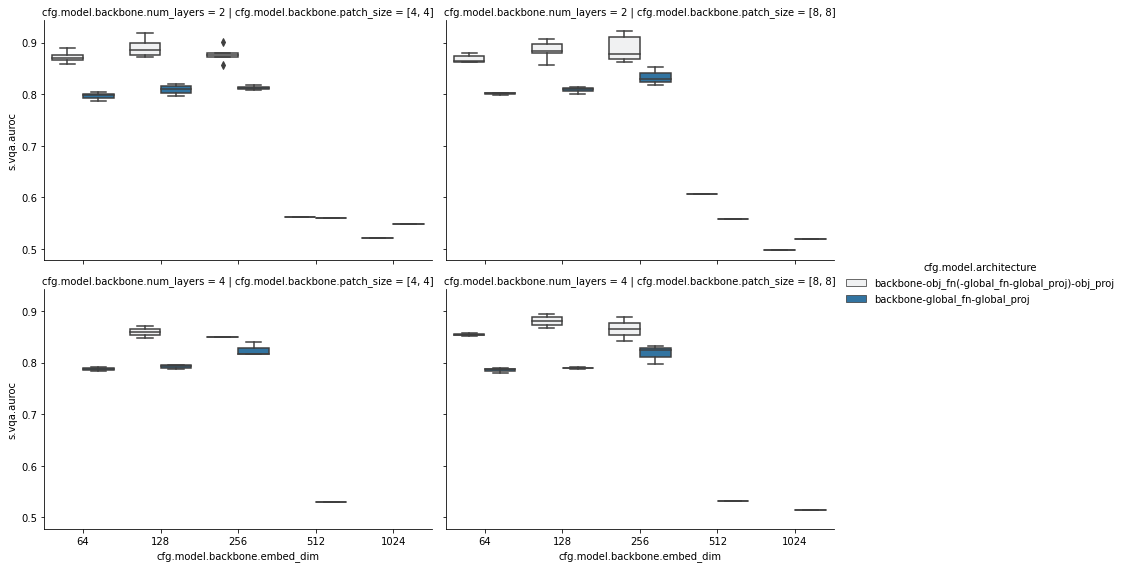

In [19]:
for metric in ["s.vqa.ap", "s.vqa.auroc"]:
    print(metric)

    df_tmp = df[
        (~df[metric].isna())
        & (df["cfg.data.crop_scale"].map(lambda v: v == [0.3, 1.0]))
        # & (df["cfg.model.backbone.patch_size"].map(lambda v: v == [8, 8]))
        # & (df["cfg.model.backbone.embed_dim"] == 64)
        # & (df["cfg.model.backbone.num_layers"] == 2)
        # & (df["cfg.model.backbone.num_heads"] == 4)
        & (
            (
                (df["cfg.model.architecture"] == "backbone-global_fn-global_proj")
            )
            | (
                (df["cfg.model.architecture"] == "backbone-obj_fn(-global_fn-global_proj)-obj_proj")
                & (df["cfg.model.obj_queries.name"] == "learned")
                & (df["cfg.model.obj_fn.name"] == "slot-attention")
                & (df["cfg.losses.l_objects.name"] == "sim_img")
                & (df["cfg.losses.l_global.weight"] > 0.0)
            )
        )
    ]

    df_tmp = df_tmp.copy()
    df_tmp["cfg.model.backbone.patch_size"] = df_tmp["cfg.model.backbone.patch_size"].astype(str)
    df_tmp["cfg.data.crop_scale"] = df_tmp["cfg.data.crop_scale"].astype(str)
    df_tmp.sort_values(["cfg.data.crop_scale","cfg.model.backbone.patch_size",],inplace=True)

    g = sns.FacetGrid(
        df_tmp,
        col="cfg.model.backbone.patch_size",
        row="cfg.model.backbone.num_layers",
        height=4,
        aspect=1.5,
    )
    g.map(
        sns.boxplot,
        "cfg.model.backbone.embed_dim",
        metric,
        "cfg.model.architecture",
        order=df_tmp["cfg.model.backbone.embed_dim"].unique().sort(),
        hue_order=df_tmp["cfg.model.architecture"].unique(),
    )
    g.add_legend(title="cfg.model.architecture")
    plt.show()

s.vqa.ap


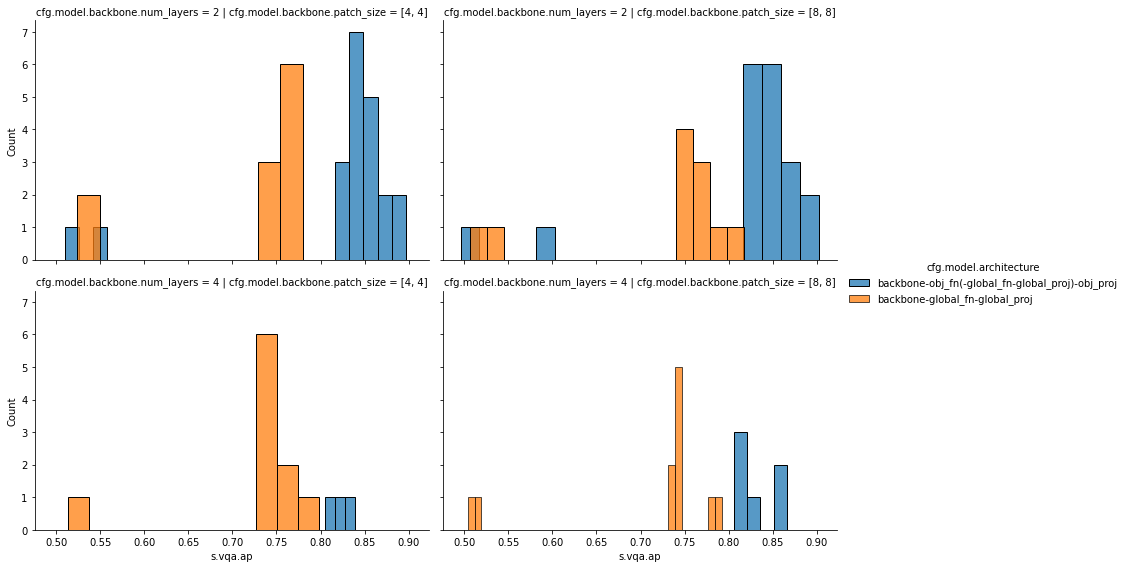

s.vqa.auroc


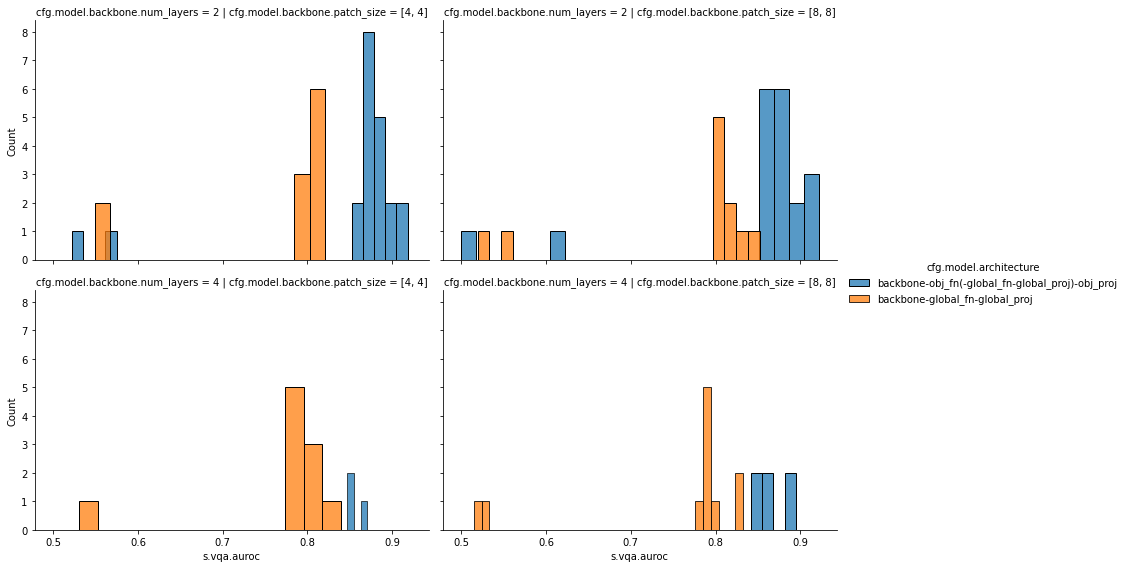

In [20]:
for metric in ["s.vqa.ap","s.vqa.auroc"]:
    print(metric)
    
    df_tmp = df[
        (~df[metric].isna())
        & (df["cfg.data.crop_scale"].map(lambda v: v == [0.3, 1.0]))
        # & (df["cfg.model.backbone.patch_size"].map(lambda v: v == [8, 8]))
        # & (df["cfg.model.backbone.embed_dim"] == 64)
        # & (df["cfg.model.backbone.num_layers"] == 2)
        # & (df["cfg.model.backbone.num_heads"] == 4)
        & (
            (
                (df["cfg.model.architecture"] == "backbone-global_fn-global_proj")
            )
            | (
                (df["cfg.model.architecture"] == "backbone-obj_fn(-global_fn-global_proj)-obj_proj")
                & (df["cfg.model.obj_queries.name"] == "learned")
                & (df["cfg.model.obj_fn.name"] == "slot-attention")
                & (df["cfg.losses.l_objects.name"] == "sim_img")
                & (df["cfg.losses.l_global.weight"] > 0.0)
            )
        )
    ]

    df_tmp = df_tmp.copy()
    df_tmp["cfg.model.backbone.patch_size"] = df_tmp["cfg.model.backbone.patch_size"].astype(str)
    df_tmp["cfg.data.crop_scale"] = df_tmp["cfg.data.crop_scale"].astype(str)
    df_tmp.sort_values(["cfg.data.crop_scale","cfg.model.backbone.patch_size",],inplace=True)

    g = sns.FacetGrid(
        df_tmp,
        col="cfg.model.backbone.patch_size",
        row="cfg.model.backbone.num_layers",
        hue="cfg.model.architecture",
        height=4,
        aspect=1.5,
    )
    g.map(sns.histplot, metric)
    g.add_legend(title="cfg.model.architecture")
    plt.show()

s.vqa.ap


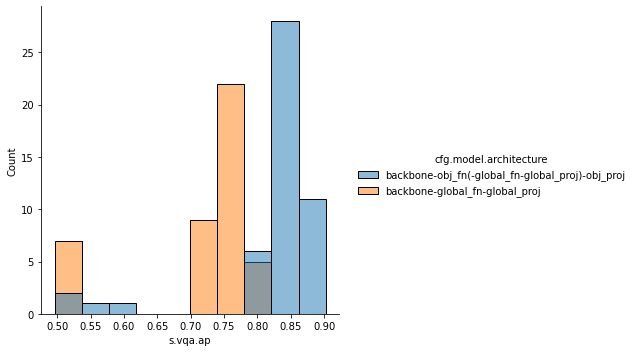

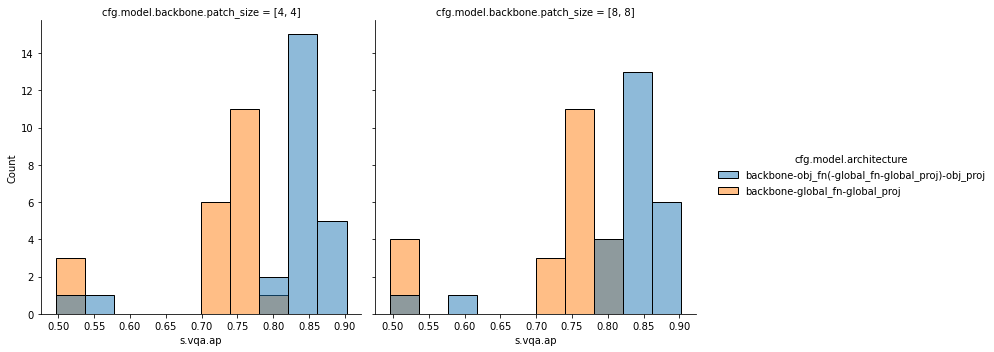

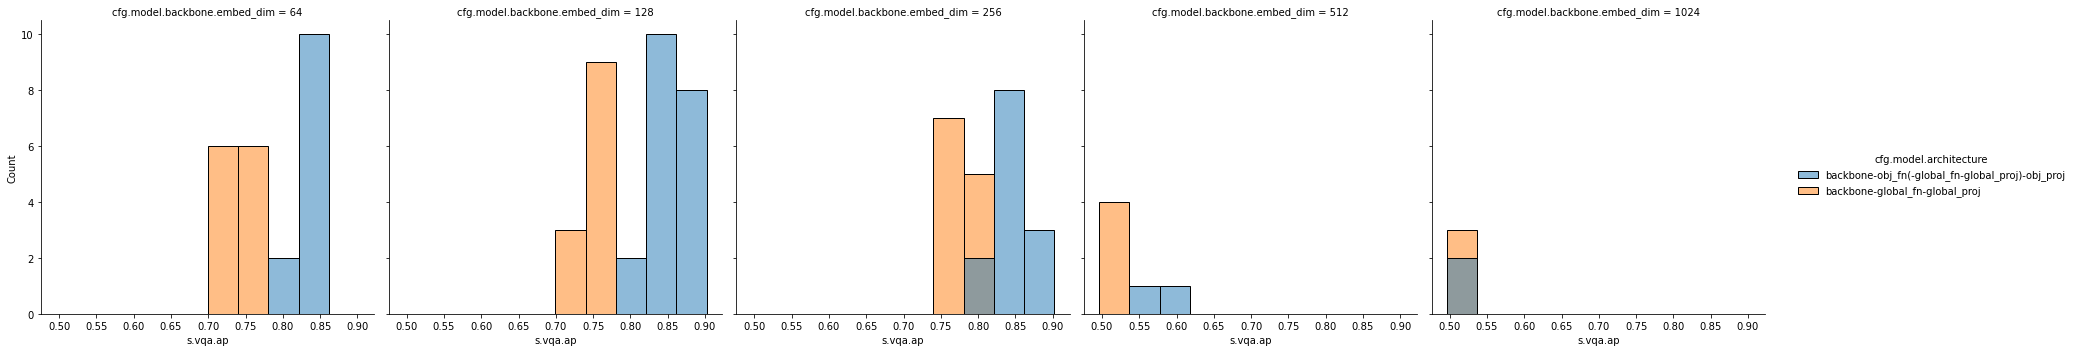

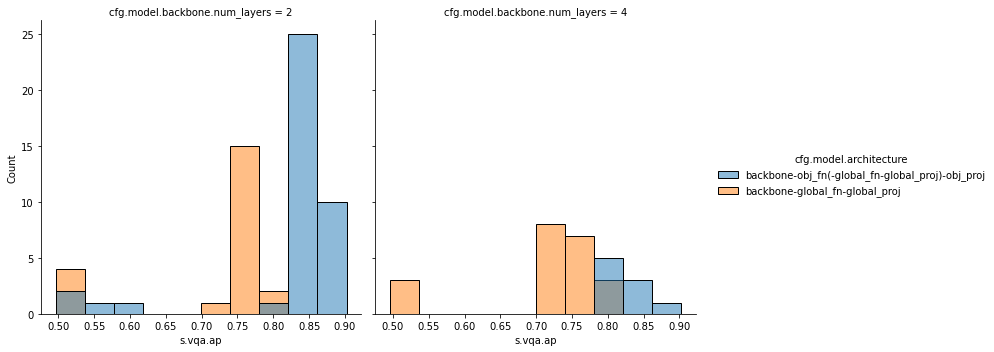

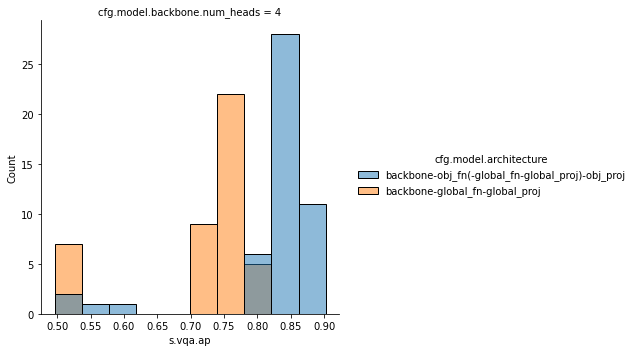

s.vqa.auroc


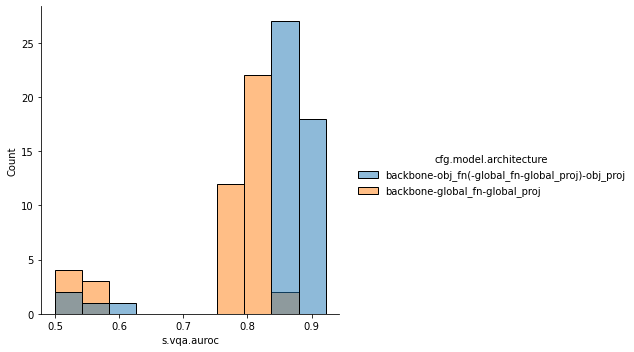

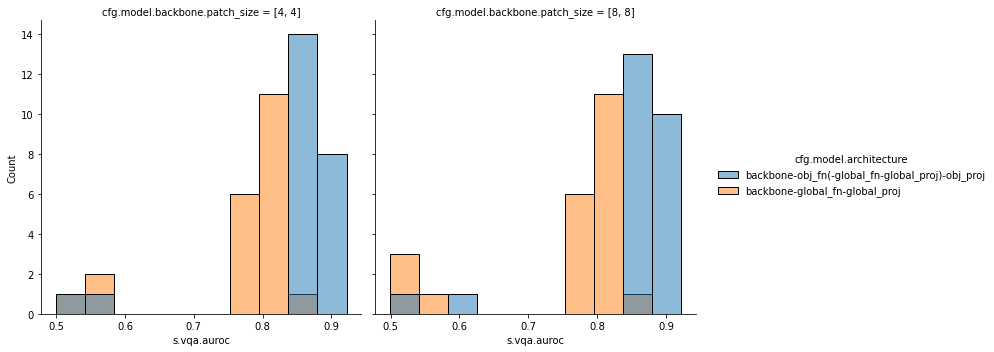

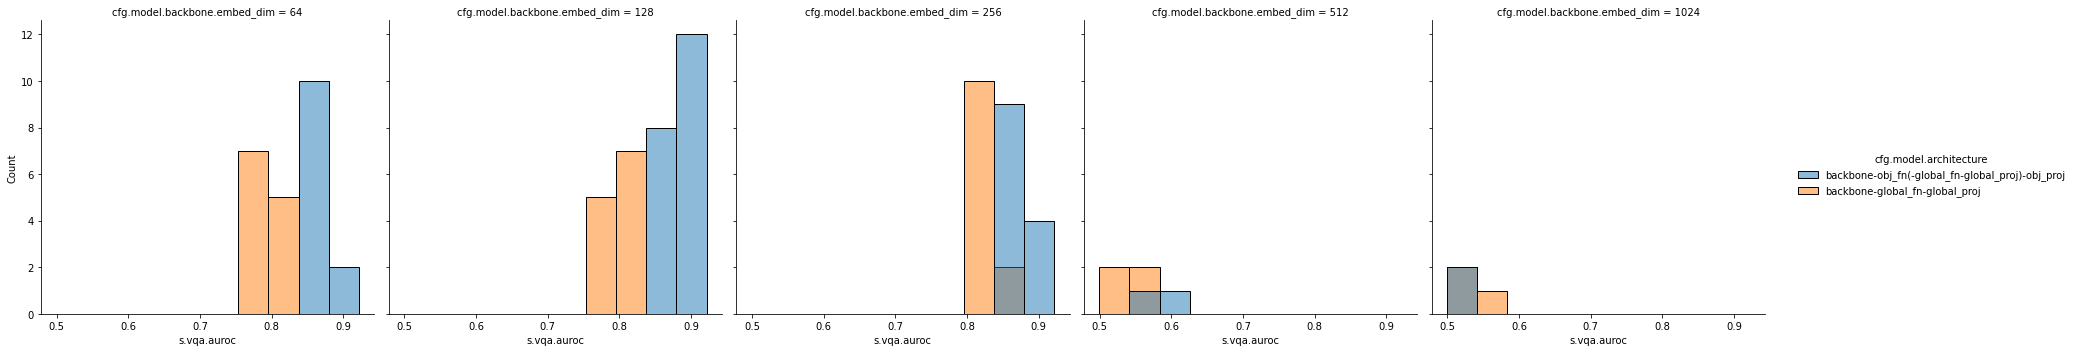

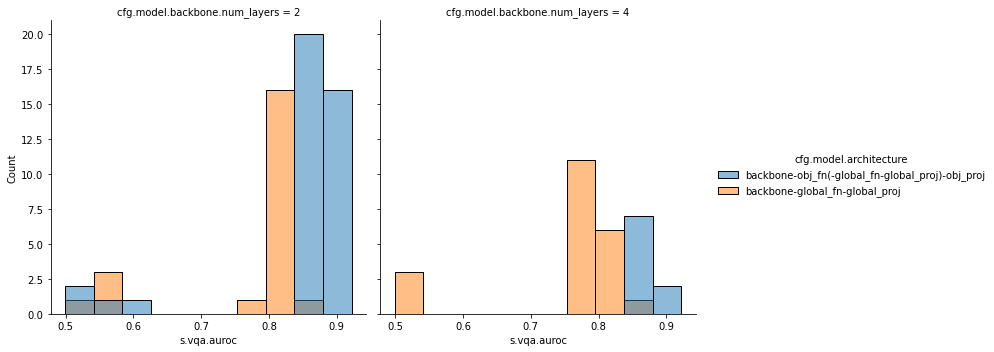

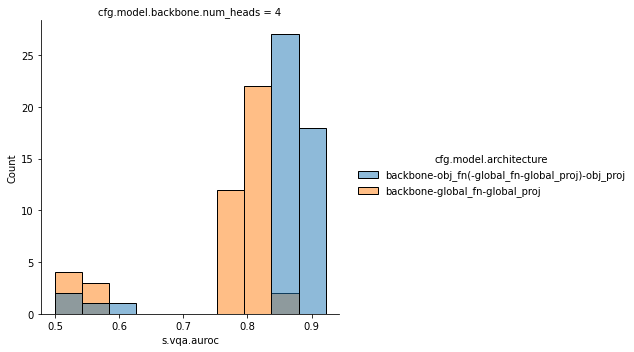

In [21]:
for metric in ["s.vqa.ap","s.vqa.auroc"]:
    print(metric)

    df_tmp = df[
        (~df[metric].isna())
        & (df["cfg.data.crop_scale"].map(lambda v: v == [0.3, 1.0]))
        # & (df["cfg.model.backbone.patch_size"].map(lambda v: v == [8, 8]))
        # & (df["cfg.model.backbone.embed_dim"] == 64)
        # & (df["cfg.model.backbone.num_layers"] == 2)
        # & (df["cfg.model.backbone.num_heads"] == 4)
        & (
            (
                (df["cfg.model.architecture"] == "backbone-global_fn-global_proj")
            )
            | (
                (df["cfg.model.architecture"] == "backbone-obj_fn(-global_fn-global_proj)-obj_proj")
                & (df["cfg.model.obj_queries.name"] == "learned")
                & (df["cfg.model.obj_fn.name"] == "slot-attention")
                & (df["cfg.losses.l_objects.name"] == "sim_img")
                & (df["cfg.losses.l_global.weight"] > 0.0)
            )
        )
    ]

    df_tmp = df_tmp.copy()
    df_tmp["cfg.model.backbone.patch_size"] = df_tmp["cfg.model.backbone.patch_size"].astype(str)
    df_tmp["cfg.data.crop_scale"] = df_tmp["cfg.data.crop_scale"].astype(str)
    df_tmp.sort_values(["cfg.data.crop_scale","cfg.model.backbone.patch_size",],inplace=True)


    for col in [
        None,
        "cfg.model.backbone.patch_size",
        "cfg.model.backbone.embed_dim",
        "cfg.model.backbone.num_layers",
        "cfg.model.backbone.num_heads",
    ]:
        sns.displot(
            df_tmp,
            x=metric,
            hue="cfg.model.architecture",
            col=col,
            bins=10,
        )
        plt.show()

## Paper plots

- Segmentation IoU
- VQA AP

In [22]:
df_tmp = df[
    (~df[metric].isna())
    & (df["cfg.data.crop_scale"].map(lambda v: v == [0.3, 1.0]))
    # & (df["cfg.model.backbone.patch_size"].map(lambda v: v == [8, 8]))
    # & (df["cfg.model.backbone.embed_dim"] == 64)
    # & (df["cfg.model.backbone.num_layers"] == 2)
    # & (df["cfg.model.backbone.num_heads"] == 4)
    & (
        (
            (df["cfg.model.architecture"] == "backbone-global_fn-global_proj")
        )
        | (
            (df["cfg.model.architecture"] == "backbone-obj_fn(-global_fn-global_proj)-obj_proj")
            & (df["cfg.model.obj_queries.name"] == "learned")
        )
    )
]

def to_group(row):
    if row["cfg.model.architecture"] == 'backbone-global_fn-global_proj':
        return 'Global Only'
    
    if row["cfg.model.obj_fn.name"] == 'slot-attention':
        if row["cfg.losses.l_global.weight"] == 0.0:
            return 'Slot (Objects only)'
        return 'Slot'
    else:
        return 'Cross'

df_tmp = df_tmp.copy()
df_tmp['Group'] = (
    df_tmp
    .apply(to_group, axis=1)
    .astype(pd.CategoricalDtype(['Global Only', 'Cross', 'Slot', 'Slot (Objects only)'], ordered=True))
)
df_tmp['Loss'] = (
    df_tmp["cfg.losses.l_objects.name"]
    .map(defaultdict(lambda: '/', {'ctr_img': 'CtrImg','ctr_all':'CtrAll','sim_img':'CosSim'}))
    .astype(pd.CategoricalDtype(['/', 'CtrAll', 'CtrImg', 'CosSim'], ordered=True))
)

df_tmp = (
    df_tmp.groupby(['Group', 'Loss'], observed=True)
    [['s.test.iou.by_img_no_bg','s.vqa.ap']]
    .agg(['max', 'mean', 'std', 'count'])
)

display(
    df_tmp.style
    .background_gradient(cmap='Blues', subset=[c[0] == 's.test.iou.by_img_no_bg' and c[1] in {'max', 'mean'} for c in df_tmp.columns], axis=None)
    .background_gradient(cmap='Oranges', subset=[c[0] == 's.vqa.ap' and c[1] in {'max', 'mean'} for c in df_tmp.columns], axis=None)
    .highlight_null('white')
    .set_caption('')
    .format(lambda v: f'{100*v:.1f}', na_rep='', subset=[c[1] in {'max', 'mean', 'std'} for c in df_tmp.columns])
)

In [67]:
df_tmp = df[
    (~df[metric].isna())
    & (df["cfg.data.crop_scale"].map(lambda v: v == [0.3, 1.0]))
    & (df["cfg.model.backbone.patch_size"].map(lambda v: v == [4, 4]))
    & (
        (
            (df["cfg.model.backbone.embed_dim"] == 128)
            & (df["cfg.losses.l_objects.name"].isin({"ctr_all", "ctr_img"}))
        ) | (
            (df["cfg.model.backbone.embed_dim"] == 256)
            & (df["cfg.losses.l_objects.name"] == "sim_img")
    ))
    # & (df["cfg.model.backbone.num_layers"] == 2)
    # & (df["cfg.model.backbone.num_heads"] == 4)
    & (df["cfg.model.architecture"] == "backbone-obj_fn(-global_fn-global_proj)-obj_proj")
    & (df["cfg.model.obj_queries.name"] == "learned")
]

def to_group(row):
    if row["cfg.model.obj_fn.name"] == 'slot-attention':
        if row["cfg.losses.l_global.weight"] == 0.0:
            return 'Slot (Objects only)'
        return 'Slot'
    else:
        return 'Cross'

df_tmp = df_tmp.copy()
df_tmp['Group'] = (
    df_tmp
    .apply(to_group, axis=1)
    .astype(pd.CategoricalDtype(['Cross', 'Slot', 'Slot (Objects only)'], ordered=True))
)
df_tmp['Loss'] = (
    df_tmp["cfg.losses.l_objects.name"]
    .map({'ctr_img': 'Contrastive Image','ctr_all':'Contrastive All','sim_img':'Cosine Similarity'})
    .astype(pd.CategoricalDtype(['Contrastive All', 'Contrastive Image', 'Cosine Similarity'], ordered=True))
)

display(
    df_tmp
    .groupby(['Group','Loss'])['s.test.iou.by_img_no_bg']
    .agg(['mean', 'std', 'count'])
    .style
    .format(lambda v: f'{100*v:.1f}', subset=['mean','std'])
)

fig, ax = plt.subplots(1, 1, figsize=1.7*np.array([4.1, 2]))
sns.barplot(x="Group", y="s.test.iou.by_img_no_bg", hue="Loss", data=df_tmp, ax=ax, palette='deep', hue_order=['Contrastive All', 'Contrastive Image', 'Cosine Similarity'])

# ax.set_ylim(0.00, 0.39)
ax.set_ylabel('Segmentation IoU %')
ax.yaxis.set_major_formatter(PercentFormatter(1.0, decimals=0, symbol=''))

ax.set_xlabel(None)
ax.set_xticklabels(['Cross\nAttention', 'Slot\nAttention', 'Slot Attention\n(no global loss)'])

ax.grid(axis='y')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(title='Object Loss', loc='upper right', framealpha=1, borderaxespad=0)

fig.tight_layout()
fig.set_facecolor('white')
fig.savefig(d/'segmentation-iou.eps')
fig.savefig(d/'segmentation-iou.svg')
# display(fig)
plt.close(fig)
display(Image(url=d/'segmentation-iou.svg', embed=False))

In [71]:
df_tmp = df[
    (~df[metric].isna())
    & (df["cfg.data.crop_scale"].map(lambda v: v == [0.3, 1.0]))
    # & (df["cfg.model.backbone.patch_size"].map(lambda v: v == [4, 4]))
    & (
        (
            (df["cfg.model.architecture"] == 'backbone-global_fn-global_proj')
        ) | (
            (df["cfg.model.backbone.embed_dim"] == 128)
            & (df["cfg.losses.l_objects.name"].isin({"ctr_all", "ctr_img"}))
        ) | (
            (df["cfg.model.backbone.embed_dim"] == 128)
            & (df["cfg.losses.l_objects.name"] == "sim_img")
    ))
    # & (df["cfg.model.backbone.num_layers"] == 2)
    # & (df["cfg.model.backbone.num_heads"] == 4)
    & (
        (
            (df["cfg.model.architecture"] == "backbone-global_fn-global_proj")
        )
        | (
            (df["cfg.model.architecture"] == "backbone-obj_fn(-global_fn-global_proj)-obj_proj")
            & (df["cfg.model.obj_queries.name"] == "learned")
        )
    )
]

def to_group(row):
    if row["cfg.model.architecture"] == 'backbone-global_fn-global_proj':
        return 'Global Only'
    
    if row["cfg.model.obj_fn.name"] == 'slot-attention':
        if row["cfg.losses.l_global.weight"] == 0.0:
            return 'Slot (Objects only)'
        return 'Slot'
    else:
        return 'Cross'

df_tmp = df_tmp.copy()
df_tmp['Group'] = (
    df_tmp
    .apply(to_group, axis=1)
    .astype(pd.CategoricalDtype(['Global Only', 'Cross', 'Slot', 'Slot (Objects only)'], ordered=True))
)
df_tmp['Loss'] = (
    df_tmp["cfg.losses.l_objects.name"]
    .map(defaultdict(lambda: '/', {'ctr_img': 'Contrastive Image','ctr_all':'Contrastive All','sim_img':'Cosine Similarity'}))
    .astype(pd.CategoricalDtype(['/', 'Contrastive All', 'Contrastive Image', 'Cosine Similarity'], ordered=True))
)

display(
    df_tmp
    .groupby(['Group','Loss'], observed=True)['s.vqa.ap']
    .agg(['mean', 'std', 'count'])
    .style
    .format(lambda v: f'{100*v:.1f}', subset=['mean','std'])
)

fig, ax = plt.subplots(1, 1, figsize=1.7*np.array([4.1, 2]))
sns.barplot(x="Group", y="s.vqa.ap", hue="Loss", data=df_tmp, ax=ax, palette='deep', hue_order=['Contrastive All', 'Contrastive Image', 'Cosine Similarity', '/'])
for r in ax.get_children():
    if isinstance(r, mpatch.Rectangle):
        if np.round(r.get_x()) == 0:
            r.set_x(-0.1)
        else:
            r.set_x(r.get_x()+.1)
    elif isinstance(r, mlines.Line2D):
        if np.round(r.get_xdata()[0]) == 0:
            r.set_xdata([-0.0, -0.0])
        else:
            r.set_xdata(r.get_xdata()+.1)

ax.set_ylim(0.48, 0.92)
ax.set_ylabel('VQA AP %')
ax.yaxis.set_major_formatter(PercentFormatter(1.0, decimals=0, symbol=''))

ax.set_xlabel(None)
ax.set_xticklabels(['Global Features\n(no object loss)', 'Cross\nAttention', 'Slot\nAttention', 'Slot Attention\n(no global loss)'])

ax.grid(axis='y')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(*zip(*[(l, t.get_text()) for t, l in zip(ax.get_legend().texts, ax.get_legend().get_patches()) if t.get_text() != '/']), 
          title='Object Loss', loc='upper right', framealpha=1, borderaxespad=0)

fig.tight_layout()
fig.set_facecolor('white')
fig.savefig(d/'vqa-ap.eps')
fig.savefig(d/'vqa-ap.svg')
plt.close(fig)
display(Image(url=d/'vqa-ap.svg', embed=False))